 
# <font color='darkblue'> Import the required packages</font>

In [1]:

### Install packages

!pip install torch
!pip install torchvision
!pip install torchsummary

In [2]:
#import PIL.ImageOps

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

#!mkdir -p drive -v


Mounted at /content/gdrive


In [4]:
import os

%cd /content/gdrive/MyDrive/Stage_M2_Jean-Eudes

!pwd

/content/gdrive/MyDrive/Stage_M2_Jean-Eudes
/content/gdrive/MyDrive/Stage_M2_Jean-Eudes


In [5]:

dir_path  = '/content/gdrive/MyDrive/Stage_M2_Jean-Eudes'
dirs = os.listdir(dir_path)

package_path = os.path.join(dir_path,'binary-stochastic-neurons-master/')
!export PYTHON_PATH=package_path

lib_package_path= os.path.join(package_path,'distributions/')

!export PYTHONPATH=package_path:lib_package_path
!export PYTHON_PATH=package_path:lib_package_path

print (package_path)

os.chdir(package_path)

/content/gdrive/MyDrive/Stage_M2_Jean-Eudes/binary-stochastic-neurons-master/


In [6]:
### Import packages from https://github.com/Wizaron/binary-stochastic-neurons
from activations import DeterministicBinaryActivation, StochasticBinaryActivation
from utils import Hardsigmoid

In [7]:
### PYTHON PATH pour mes fichiers


cwd = os.getcwd()
dir_mypackages  = '/content/gdrive/MyDrive/Stage_M2_Jean-Eudes/MonCode/'
dirs = os.listdir(dir_path)

#package_path = os.path.join(dir_path,'binary-stochastic-neurons-master/')
#!export PYTHON_PATH=package_path

#lib_package_path= os.path.join(package_path,'distributions/')

!export PYTHONPATH=$PYTHONPATH:dir_mypackages
!export PYTHON_PATH=$PYTHON_PATH:dir_mypackages

print (dir_mypackages)

os.chdir(dir_mypackages)

/content/gdrive/MyDrive/Stage_M2_Jean-Eudes/MonCode/


In [8]:

### Imports Packages standards

import itertools
import math
import time
import numpy as np
from easydict import EasyDict as edict
import tempfile
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset 
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim


from torchsummary import summary
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr



In [9]:
### Init variables globales

Sauve_figures = False
use_cuda=True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [10]:
print(device)

cpu



# <font color='darkblue'> Data</font>

In [11]:

n_epochs = 10
batch_size_train = 128
batch_size_test = 256 
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [12]:

#t = torchvision.transforms.Compose([
#                       torchvision.transforms.ToTensor(),
#                       torchvision.transforms.Normalize(mean=(0), std=(1))]
#                       )

mnist_train = torchvision.datasets.MNIST(root=tempfile.gettempdir(), train=True, download=True,) #'./'

X_mnist_train, y_mnist_train = (mnist_train.data)/255., (mnist_train.targets)
X_mnist_train = X_mnist_train.reshape((len(mnist_train),1,28,28))

mnist_test = torchvision.datasets.MNIST(root=tempfile.gettempdir(),train=False, download=True,)
                             #transform=t)

X_mnist_test, y_mnist_test = (mnist_test.data)/255., (mnist_test.targets)
X_mnist_test =X_mnist_test.reshape((len(mnist_test),1,28,28))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw



In [13]:
class customDataset(Dataset):
    ''' 
        Create a dataloader which takes a tuples of mnist data and "one" 
    '''    

    def __init__(self, x_mnist_data, input_1):

        self.x_mnist_data = x_mnist_data
        self.input_1 = input_1

        
    def __getitem__(self, index):
        sample = {'x_mnist_data': self.x_mnist_data[index], 'input_1': self.input_1[index]}
        return sample
    
    def __len__(self):
        return len(self.x_mnist_data)

In [14]:
X_mnist_train.shape

torch.Size([60000, 1, 28, 28])

In [15]:
len(X_mnist_train)

60000

In [16]:
def transform_data(x_train, x_test, config, normalize = "none",batch_size_train  =128, batch_size_test = 256): 
  
  """return the data loader of test and train after a normalization

   x_train, x_test are basically : X_mnist_train and X_mnist_test. they are already normalize in image domain (/255). if we want, we can also apply a standard scaler"""

  train_size = x_train.shape[0]
  test_size= x_test.shape[0]

  if config.complexe == False:

      dataset = customDataset( x_train.to(device),  torch.ones((train_size,1,1,1)).float().to(device) )

      train_loader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True )

      dataset_test = customDataset( x_test.to(device), torch.ones((test_size,1,1,1)).float().to(device) )

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False )
        

  elif config.complexe == True:

      x_train = np.fft.fft2(x_train, axes=(2,3)) ##x_train is of shape 60000,1,28,28 . fft direct : il est non centré

      x_test = np.fft.fft2(x_test, axes=(2,3)) ##x_test is of shape 10000,1,28,28. fft direct : il est non centré      

      if normalize == "minmax":
        x_train = x_train/np.max(np.abs(x_train)) 
        x_test = x_test/np.max(np.abs(x_test)) 
      
      elif normalize == "standartscale":
        x_train = ( x_train - np.mean(x_train) ) / np.std(x_train)
        x_test = ( x_test - np.mean(x_test) ) / np.std(x_test)

      elif normalize == "none":
        pass

      x_train = torch.stack((torch.from_numpy(x_train.real), torch.from_numpy(x_train.imag)),dim=-1).float().to(device)
      x_test =  torch.stack((torch.from_numpy(x_test.real), torch.from_numpy(x_test.imag)),dim=-1).float().to(device)

      dataset = customDataset(x_train, torch.ones((train_size,1,1,1)).float().to(device))
      train_loader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True )

      dataset_test = customDataset(x_test , torch.ones((test_size,1,1,1)).float().to(device))
      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False )

  return train_loader, test_loader
  


# <font color='darkblue'> Visualisation </font>

One may use direct fft of the data, or shift them before applying the fft. For that, there may be two ways of proceding : use a simple fftshift, or for example applying the fftshift that is applied for mri kspace (Swetali codes...) 

In [45]:
ft_train_1 = np.fft.fft2(X_mnist_train, axes=(2,3)) ##X_mnist_train is of shape 60000,1,28,28 . fft direct, non centré
ft_train_2 = np.fft.fftshift(np.fft.fft2(X_mnist_train, axes=(2,3))) ##ici on a directement l'image à partir du non centré fft

inv_ft_train_1 =  np.fft.ifft2(ft_train_1, axes = (2,3))  ##fft est centré
inv_ft_train_2 = np.fft.ifft2(np.fft.ifftshift(ft_train_2),axes=(2,3))## décentré le fft centré puis appliquer le ifft

In [18]:
##from Swetali codes

from numpy.fft import fftshift, ifftshift, fftn, ifftn


def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    #img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img
  
def transform_image_to_kspace(img, dim=None, k_shape=None):
  """ Computes the Fourier transform from image space to k-space space
  along a given or all dimensions
  :param img: image space data
  :param dim: vector of dimensions to transform
  :param k_shape: desired shape of output k-space data
  :returns: data in k-space (along transformed dimensions)
  """
  if not dim:
      dim = range(img.ndim)

  k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim) # fftshi()
  #k /= np.sqrt(np.prod(np.take(img.shape, dim)))
  return k

In [19]:
ft_train_3 = transform_image_to_kspace(X_mnist_train, dim=(2,3)) ## fft utilisé dans mnist
inv_ft_train_3 =  transform_kspace_to_image(ft_train_3, dim=(2,3))  ##inverse



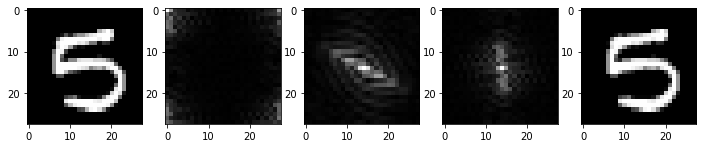

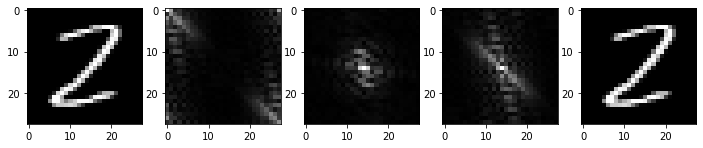

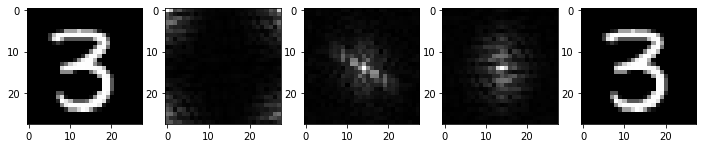

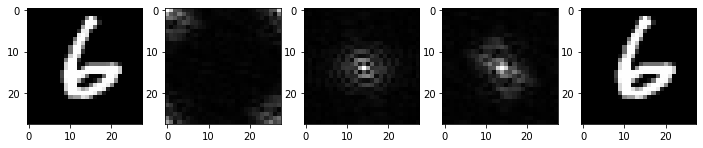

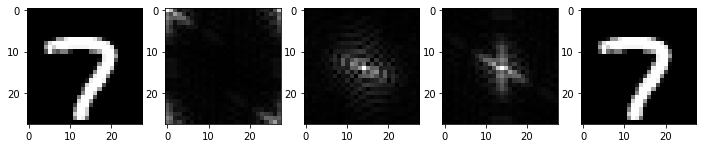

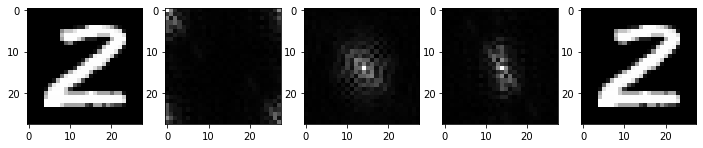

In [47]:
np.random.seed(119)

for t in np.random.choice(len(X_mnist_train), 6):

  f,axarr=plt.subplots(1,5,figsize=(12, 8))

  axarr[0].imshow(X_mnist_train[t].squeeze(),cmap ="Greys_r") ##original
  axarr[1].imshow(np.abs(ft_train_1[t].squeeze()),cmap ="Greys_r") #fft direct  
  axarr[2].imshow(np.abs(ft_train_2[t].squeeze()),cmap ="Greys_r") #with fftshift direct

  axarr[3].imshow(np.abs(ft_train_3[t].squeeze()),cmap ="Greys_r") #with swetali code (for mri kspace)
  axarr[4].imshow(np.abs(inv_ft_train_2[t].squeeze()),cmap ="Greys_r") #ou inv_ft_train_1 ou inv_ft_train_2 ou inv_ft_train_3 ou encore X_mnist_train

  plt.show()

# <font color='darkblue'> Tools</font>

##Winner takes all (wta)

In [21]:

class SparsifyBase(nn.Module):
    def __init__(self, sparse_ratio=0.5):
        super(SparsifyBase, self).__init__()
        self.sr = sparse_ratio
        self.preact = None
        self.act = None

    def get_activation(self):
        def hook(model, input, output):
            self.preact = input[0].cpu().detach().clone()
            self.act = output.cpu().detach().clone()
        return hook

    def record_activation(self):
        self.register_forward_hook(self.get_activation())


class Sparsify1D(SparsifyBase):
    def __init__(self, sparse_ratio=0.5):
        super(Sparsify1D, self).__init__()
        self.sr = sparse_ratio

    def forward(self, x):
        k = int(self.sr *x.shape[1])
        topval = x.topk(k, dim=1)[0][:, -1]
        topval = topval.expand(x.shape[1], x.shape[0]).permute(1 ,0)
        comp = ( x>=topval).to(x)
        return comp *x

class Sparsify1D_kactive(SparsifyBase):
    def __init__(self, k=1):
        super(Sparsify1D_kactive, self).__init__()
        self.k = k

    def forward(self, x):
        k = self.k
        topval = x.topk(k, dim=1)[0][:, -1]
        topval = topval.expand(x.shape[1], x.shape[0]).permute(1 ,0)
        comp = ( x>=topval).to(x)
        return comp *x
      
 
 
class Sparsify1D_kactiveIOnline(SparsifyBase):
    def __init__(self, config):                                          
        super(Sparsify1D_kactiveIOnline, self).__init__()
                
        self.height_mask = config.mask_dim[0]
        self.width_mask = config.mask_dim[1]
        self.acc = config.acceleration ## acceleration en proportion
        self.slice_dim = config.slice_dim #tuple or list of the height and width of k-space
        
        self.k = int((self.slice_dim[0]*self.slice_dim[1])*self.acc) # + self.acs_points # nombre total de points acquis, acs y compris ; 
        self.k_per_under_mask = math.ceil((self.height_mask)*(self.width_mask) * self.k / (self.slice_dim[0]*self.slice_dim[1]))  
                                              
            
    def forward(self, x):#, k=0):
        #if (k==0):
        #  k = self.k
        #else:
        #  self.k = k
        topval = x.topk(self.k_per_under_mask, dim=1)[0][:, -1]
        topval = topval.expand(x.shape[1], x.shape[0]).permute(1 ,0)
        comp = ( x>=topval).to(x)
        return comp *x



##SPIRIT

In [22]:
##for  real data
#SPIRiT as single conv layer with kernel(centre) = 0
class RealSpirit2D(nn.Module):
    
    def __init__(self, config):
        
        super(RealSpirit2D,self).__init__()
        
        #define local variables
        self.config = config
        self.kernel_size = self.config.kernel1 
        self.ncoils = self.config.ncoils
        self.activation = config.spirit_activation
        if self.config.batch_norm==True:
          self.bn_layer = nn.BatchNorm2d(self.ncoils)
        
        #self.nslices = config.batch_size #choosen_batch_size #self.config.nslices # REMPLACER PAR choosen_batch_size  divisible par le nombre d'exemple d'appprentissage total; le batch_size doit être = nb slice à processer
        #self.conv0 = nn.Conv2d(in_channels= self.ncoils * self.nslices , out_channels=self.ncoils*self.nslices, kernel_size=self.kernel_size, bias=False,  padding=(self.kernel_size[0]//2, self.kernel_size[1]//2))                                                   
        self.conv0 = nn.Conv2d(in_channels= self.ncoils , out_channels=self.ncoils, kernel_size=self.kernel_size, bias=False, padding=(self.kernel_size[0]//2, self.kernel_size[1]//2))                                   


    def forward(self, x):          
        
        with torch.no_grad():
            self.conv0.weight[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 0

        if self.activation =="relu":
          z= F.relu(self.conv0(x)) 
        elif self.activation =="leaky_relu":
          z= F.leaky_relu(self.conv0(x))
        elif self.activation =="none":
          z= self.conv0(x)

        if self.config.batch_norm==True:
          return self.bn_layer(z)
        else:
          return z

        
class SpiritConvBlock(nn.Module):
    """
    Model block for spirit network.
    This model applied spirit to undersampled data. A series of these blocks can be stacked to form
    the full network.
    """

    def __init__(self, model):
        """
        Args:
            model: Spirit model.
        """
        super().__init__()

        self.model = model

    def forward(self,
        current_img: torch.Tensor, #current_kspace: torch.Tensor,
        ref_img: torch.Tensor, #ref_kspace: torch.Tensor,
        mask: torch.Tensor):
        
        x = self.model(current_img)
        
        #data consistency
        out = torch.multiply(x,1-mask) + torch.mul(ref_img, mask) #out = torch.multiply(x,1-mask) + ref_img
        #torch.mul(ref_img, mask)
        return out
    
    
#Stack SpiritConv N times
class stackSpirit(nn.Module):
    def __init__(self, config):
        
        super().__init__() 

        self.config = config 
        
        #N times spirit is applied
        self.num_stacks = self.config.spirit_block

        #intermediate/auxiliar reconstruction ; 
        self.auxiliary = self.config.auxiliary  ##true or false
        
        self.body = nn.ModuleList(
            [SpiritConvBlock(RealSpirit2D(config)) for _ in range(self.num_stacks)]
        )

    def forward(self,
        masked_img: torch.Tensor, #masked_kspace: torch.Tensor,
        mask: torch.Tensor,):
        
      img_pred = masked_img.clone()  #kspace_pred = masked_kspace.clone()

      if (self.auxiliary == False):
        for stack in self.body:
            img_pred = stack(img_pred, masked_img, mask)
            #kspace_pred = stack(kspace_pred, masked_kspace, mask)
        
        return img_pred #kspace_pred

      elif self.auxiliary == True:

        auxiliary_reconstruction = []
        for stack in self.body:
            img_pred = stack(img_pred, masked_img, mask)
            #kspace_pred = stack(kspace_pred, masked_kspace, mask)
            auxiliary_reconstruction.append(img_pred)
        return auxiliary_reconstruction #kspace_pred  


      

In [23]:
##for complexe data

class complexConv2d(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size=3, stride=1, padding = 0,dilation=1, groups=1, bias=False):
        
        super(complexConv2d, self).__init__()

        self.conv_r = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.conv_i = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)

    def forward(self,input_r, input_i):
        return self.conv_r(input_r)-self.conv_i(input_i), \
               self.conv_r(input_i)+self.conv_i(input_r)


#SPIRiT as single conv layer with kernel(centre) = 0
class Complexspirit2D(nn.Module):
    
    def __init__(self, config):
        
        super(Complexspirit2D,self).__init__()
        
        #define local variables
        self.config = config
        self.kernel_size = self.config.kernel1 
        self.ncoils = self.config.ncoils

        self.activation = config.spirit_activation
        if self.config.batch_norm==True:
          self.bn_layer = nn.BatchNorm2d(self.ncoils)
        
        #self.nslices = config.batch_size #choosen_batch_size #self.config.nslices # REMPLACER PAR choosen_batch_size  divisible par le nombre d'exemple d'appprentissage total; le batch_size doit être = nb slice à processer
        self.conv1 = complexConv2d(in_channels= self.ncoils , out_channels=self.ncoils, kernel_size=self.kernel_size, bias=False, padding=(self.kernel_size[0]//2, self.kernel_size[1]//2))
    
    def forward(self, x):
        
        (x_real,x_img) = x[...,0],x[...,1]  
        
        with torch.no_grad():
            self.conv1.conv_r.weight[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 0
            self.conv1.conv_i.weight[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 0
        
        (x_real,x_img) = self.conv1(x_real,x_img)
        (x_real,x_img) =(torch.unsqueeze(x_real, 4), torch.unsqueeze(x_img, 4))
        
        z= torch.cat((x_real,x_img),-1)

        if self.activation =="relu":
          z= F.relu(z)
        elif self.activation =="leaky_relu":
          z= F.leaky_relu(z)
        elif self.activation =="none":
          z= z #this is not well writen

        if self.config.batch_norm==True:
          return self.bn_layer(z)
        else:
          return z

        
class ComplexSpiritConvBlock(nn.Module):
    """
    Model block for spirit network.
    This model applied spirit to undersampled data. A series of these blocks can be stacked to form
    the full network.
    """

    def __init__(self, model):
        """
        Args:
            model: Spirit model.
        """
        super().__init__()

        self.model = model

    def forward(self,
        current_kspace: torch.Tensor,
        ref_kspace: torch.Tensor,
        mask: torch.Tensor):
        
        x = self.model(current_kspace)
        #data consistency
        out = torch.multiply(x,1-mask) + torch.mul(ref_kspace, mask) #torch.multiply(x,~mask) + ref_kspace
        
        return out
    
    
#Stack SpiritConv N times
class ComplexstackSpirit(nn.Module):
    def __init__(self, config):
        
        super().__init__() 

        #define local variables
        self.config = config 
        
        #N times spirit is apply
        self.num_stacks = self.config.spirit_block

        #intermediate/auxiliar reconstruction ; 
        self.auxiliary = self.config.auxiliary  ##true or false
        
        self.body = nn.ModuleList(
            [ComplexSpiritConvBlock(Complexspirit2D(config)) for _ in range(self.num_stacks)]
        )

    def forward(self,
        masked_kspace: torch.Tensor,
        mask: torch.Tensor,):
        
        kspace_pred = masked_kspace.clone()

        if (self.auxiliary == False):
          for stack in self.body:
              kspace_pred = stack(kspace_pred, masked_kspace, mask)
          
          return kspace_pred


        elif self.auxiliary == True:

          auxiliary_reconstruction = []
          for stack in self.body:
              #img_pred = stack(img_pred, masked_img, mask)
              kspace_pred = stack(kspace_pred, masked_kspace, mask)
              auxiliary_reconstruction.append(kspace_pred)
          return auxiliary_reconstruction #kspace_pred  





# <font color='darkblue'> Model</font>




In [24]:
class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, din):
        if self.training:
            #return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
            return din + torch.autograd.Variable(torch.randn(din.size()).to(device) * self.stddev)
        return din

In [59]:
class Net(nn.Module):

    def __init__(self, bin_act_type = "determinist", config=None):
        super(Net, self).__init__()

        self.img_h = config.slice_dim[0] ##nb rows for the inmput image
        self.img_w = config.slice_dim[1] ##nb col for the inmput image
        self.height_mask = config.mask_dim[0]
        self.width_mask = config.mask_dim[1]
        #self.k_per_under_mask = k_per_under_mask
        self.config = config
        self.std_noise = config.std_noise
        self.dropout_proba = config.dropout_proba                

        self.bin_act_type = bin_act_type
        self.conv_mask = nn.ConvTranspose2d(in_channels = 1, out_channels =1, kernel_size = (self.height_mask, self.width_mask), groups=1, bias=False)      
        
        self.DO1 = nn.Dropout(p = self.dropout_proba, inplace=False)
        self.noise = GaussianNoise(self.std_noise)

        self.binary_act_d = DeterministicBinaryActivation(estimator='ST')
        self.binary_act_s = StochasticBinaryActivation(estimator='ST')
        
        self.slope = config.slope #1.0 
        self.linear_sp = self.linear_sp = Sparsify1D_kactiveIOnline(config) #Sparsify1D_kactiveIOnline(self.height_mask, self.width_mask, k_per_under_mask = self.k_per_under_mask)
        print("Number of acquired points in the whole mask :",self.linear_sp.k ); print(f"Number of acquired points in the local mask of size {config.mask_dim} :",self.linear_sp.k_per_under_mask )

        if self.config.complexe ==False:
          self.spirit_nn = stackSpirit(self.config) 
          print("stackSpirit")

        elif self.config.complexe ==True:
          self.spirit_nn = ComplexstackSpirit(self.config)
          print("ComplexstackSpirit")    

        if self.config.multicoil == True and self.config.complexe == False: 
          self.sensitivity_conv = nn.Conv2d(in_channels = 1, out_channels = self.config.ncoils, kernel_size = (5, 5), groups=1, bias=False, padding="same")  
          self.back_to_img_dim_conv = nn.Conv2d(in_channels =  self.config.ncoils, out_channels =1, kernel_size = (5, 5), groups=1, bias=False, padding="same")
        
        elif self.config.multicoil == True and self.config.complexe == True:
          self.sensitivity_conv = nn.Conv2d(in_channels = 1, out_channels = self.config.ncoils, kernel_size = (5, 5), groups=1, bias=False, padding="same")  
          self.back_to_img_dim_conv_r = nn.Conv2d(in_channels =  self.config.ncoils, out_channels =1, kernel_size = (5, 5), groups=1, bias=False, padding="same")
          self.back_to_img_dim_conv_i = nn.Conv2d(in_channels =  self.config.ncoils, out_channels =1, kernel_size = (5, 5), groups=1, bias=False, padding="same")



    def forward(self, x, my_input_1):

        sig_output = F.sigmoid((self.conv_mask(my_input_1)))       
        
        #sig_output= self.DO1(sig_output) # commente dans celui qui fonctionne

        if self.bin_act_type == "determinist": # add noise and use deterministic binary activation with

          sig_output = self.noise(sig_output) # variance plus forte ici
          x2 = sig_output.view(sig_output.size()[0],-1)        
          x2 = self.linear_sp(x2)        
          wta_output = x2.view_as(sig_output) 
                 
          #wta_output = self.linear_sp(sig_output)        
             
          binary_mask = self.binary_act_d([wta_output, self.slope]) #shape : [1,1,self.height_mask, self.width_mask] . WHY NOW [batch_size,1,self.height_mask, self.width_mask]
        
        elif self.bin_act_type == "stochastic": # add noise and use deterministic binary activation with
          x2 = sig_output.view(sig_output.size()[0],-1)        
          x2 = self.linear_sp(x2)        
          wta_output = x2.view_as(sig_output)    
          binary_mask = self.binary_act_s([wta_output, self.slope]) #shape : [1,1,self.height_mask, self.width_mask] . WHY NOW [batch_size,1,self.height_mask, self.width_mask], the mask is specific to each input ?


        ##ajuster la taille du masque à celle de l'image                                                                      
        binary_mask_adj = torch.tile(binary_mask[:,:,], (math.ceil(self.img_h/self.height_mask),math.ceil(self.img_w/self.width_mask)))[:,:,:self.img_h,:self.img_w] # x shape :[batch_size,n_channel,h,w] ; x.shape[-2] =x.shape[-1] = 28
        
        
        if self.config.multicoil == True:
          if self.config.complexe ==True: 

              x_real, x_img = x[...,0],x[...,1]  
                        
              x_real_sensitivity  = self.sensitivity_conv(x_real) ; x_img_sensitivity =self.sensitivity_conv(x_img)

              (x_real,x_img) =(torch.unsqueeze(x_real_sensitivity, 4), torch.unsqueeze(x_img_sensitivity, 4))
        
              x = torch.cat((x_real,x_img),-1) #shape [batch_size, 8, 28, 28, 2]

          else:
              x = self.sensitivity_conv(x) #shape [batch_size, 8, 28, 28]
          
                        
        if self.config.complexe ==True:          
          stack_binary_mask_adj = torch.stack((binary_mask_adj, binary_mask_adj), dim=-1,)  # ajouter la dimension complexe , shape : [batch_size, 1, 28,28,2] ou [batch_size, ncoils, 28,28,2]

          x  = torch.mul(stack_binary_mask_adj,x) 
          reconstructed_img = self.spirit_nn(x, stack_binary_mask_adj) ##more precisely it is the reconstructed "kspace" : [batch_size, 8, 28, 28] or [batch_size, 1, 28, 28]
          print()
                  
        else:

          x  = torch.mul(binary_mask_adj,x) ## shape [batch_size, 1, 28,28] ou [batch_size, ncoils, 28,28]
          #print("x après mul shape: ", x.shape)
          reconstructed_img = self.spirit_nn(x, binary_mask_adj)  

        if self.config.multicoil == True  and self.config.complexe == False:
          reconstructed_img = self.back_to_img_dim_conv(reconstructed_img)  

        elif self.config.multicoil == True and self.config.complexe == True:
          reconstructed_img_r = self.back_to_img_dim_conv_r(reconstructed_img[...,0])      
          reconstructed_img_i = self.back_to_img_dim_conv_r(reconstructed_img[...,1]) ### back_to_img_dim_conv_i

          reconstructed_img = torch.cat((reconstructed_img_r.unsqueeze(-1) , reconstructed_img_i.unsqueeze(-1)),-1)


        return reconstructed_img, binary_mask_adj, binary_mask  
                          

In [26]:
# https://stackoverflow.com/questions/51748138/pytorch-how-to-set-requires-grad-false
##this function will allow to freeze the parameters of the coils sensitivity convolution, if we use "multicoil"

def weight_init(model):
  #nn.init.normal_(model.senstivity_conv.weight)
  for param in model.sensitivity_conv.parameters():
    param.requires_grad = False



# <font color='darkblue'> Learning</font>



In [27]:
def define_opt(network, lr_mask = 1e-3, lr_other = 1e-2,algo =optim.Adam  ):

  my_list = ['conv_mask.weight']

  params = list(filter(lambda kv: kv[0] in my_list, network.named_parameters()))
  base_params = list(filter(lambda kv: kv[0] not in my_list, network.named_parameters()))
  d = dict((y, x) for x, y in base_params)
  #optimizer_mask = optim.Adam(params,lr=0.001)
  #optimizer_model = optim.Adam(base_params,lr=0.01)

  optimizer = algo([ 
                                {'params': d}, 
                                {'params': network.conv_mask.parameters(), 'lr': lr_mask} 
                                ], lr=lr_other)
  return optimizer
                              

 
# <font color='darkblue'> Functions for training and testing </font>


 
### <font color='darkblue'> Weighted loss  </font>


In [28]:
def weight_function(config,n_spirit_block ,plot = True):
     
    config = edict(config)

    output = torch.ones((1,1,config.slice_dim[0],config.slice_dim[1]))

    fix_conv = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = (config.kernel1[0],config.kernel1[1]), padding ="same")
    
    with torch.no_grad():
        fix_conv.weight[:] = 1/(config.kernel1[0]*config.kernel1[1]) ## should depend on kernel size

    fix_conv.weight[:].require_grad = False
    
    for i in range(n_spirit_block):  
        output = fix_conv(output)
        
        output = output.detach()
        if plot==True:
            plt.imshow(output[0,0,:,:],cmap = "Greys_r")
            plt.title(f"bloc {i+1}")
            plt.show()
        
    return output

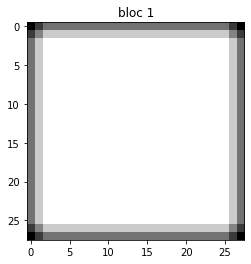

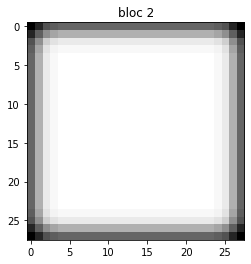

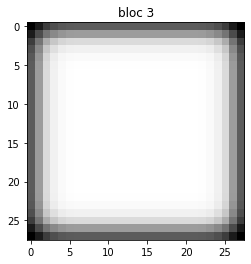

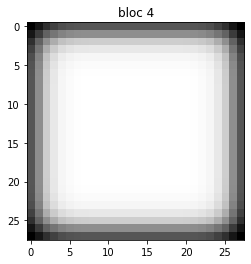

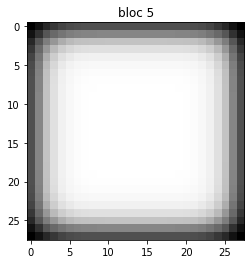

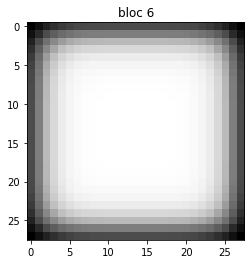

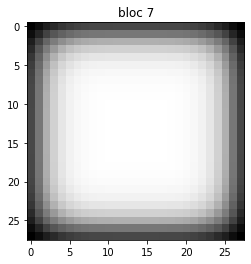

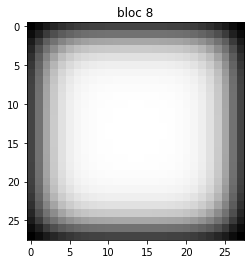

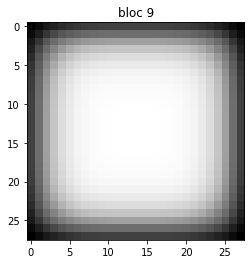

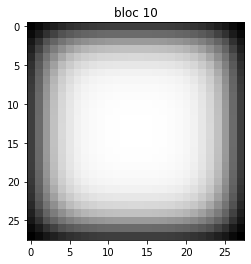

In [29]:
###example
ex_config = {
    "batch_size": 128, 
    "kernel1": [5,5],
    "ncoils" : 1, 
    "nslices" : 1,
    "spirit_block" : 5,
    "std_noise": 0.05,
    "dropout_proba": 0.,
    "slice_dim" : (28,28),
    "multicoil": False,
    "mask_dim" : (28,28),
    "slope": 1,
    "complexe":False,
    "lr_mask": 1e-3,
    "lr_other": 1e-2,
    "spirit_activation": "none", ##activation function after spirit
    "batch_norm": False, #for bn_list
    "main_directory":".",
    "auxiliary":False,
    "weight_loss" :True
}

example_weight= weight_function(config = ex_config, n_spirit_block = 10,plot = True) ##note that although the n_spirit_block is already present in the config, we prefer set it as a parameter for the functio

In [58]:
def test_spirit_2(network,criterion,config, loader):

  network.eval()
  test_loss = 0
  output_array =[]
  input_array = []


  if config.weight_loss == True and config.auxiliary==False:
    loss_weight = weight_function(config, n_spirit_block= config.spirit_block ,plot = False).to(device)
    if config.complexe == True:
      loss_weight = torch.stack((loss_weight, loss_weight), dim=-1,) ##we need to stack for real and imaginary part
  
  
  elif config.weight_loss == True and config.auxiliary==True:
  
    loss_weight_list = [weight_function(config, n_spirit_block= i , plot = False).to(device) for i in range(1,config.spirit_block+1)]
    
    if config.complexe == True:
      loss_weight_list = [torch.stack((weight, weight), dim=-1,) for weight in loss_weight_list]



  #print("*********** TEST *************")
  with torch.no_grad():
    for batch_idx, sample in enumerate(loader):
      input, ones_data = sample['x_mnist_data'], sample['input_1']
    
      output,  learned_mask_adj, learned_mask = network(input,ones_data) ##here the output is image
      
      ###compute loss

      if config.auxiliary==False :

        if  config.weight_loss == False:
           test_loss += criterion(output, input).item()*input.size(0) #criterion_MSE(output, input).item()*input.size(0)

        elif config.weight_loss == True:
            test_loss += sum([criterion(torch.mul(loss_weight,output), torch.mul(loss_weight,input)) for i in range(len(output))])       #here len(output) = nb_bloc_spirit; maybe we can apply different weight

        output_array.append(output) 
        input_array.append(input) 

      else:

        if config.auxiliary==False :

            test_loss += sum([criterion(output[i], input) for i in range(len(output))]).item()*input.size(0) #criterion_MSE(output, input).item()*input.size(0)


        elif config.weight_loss == True:
            test_loss += sum([criterion(torch.mul(loss_weight_list[i],output[i]), torch.mul(loss_weight_list[i],input)) for i in range(len(output))]) 

        output_array.append(output[-1]) ##take only the last reconstruction
        input_array.append(input)


  test_loss /= len(loader.dataset) ##this is the loss on the whole test set

  input_array = np.array(torch.vstack(input_array).cpu())
  output_array = np.array(torch.vstack(output_array).cpu())


  if config.complexe ==True:
    print("input_array shape: ", input_array.shape)
    input_array_complex = input_array[...,0] +1j*input_array[...,1] 
    input_array = np.fft.ifft2(input_array_complex, axes=(2,3)) #transform_kspace_to_image(input_array_complex, dim=(2,3))  #input_array = np.fft.ifft2(input_array_complex, axes=(2,3)) 
    input_array = np.abs(input_array)

    output_array_complex = output_array[...,0] +1j*output_array[...,1]
    output_array = np.fft.ifft2(output_array_complex, axes=(2,3))  #transform_kspace_to_image(output_array_complex, dim=(2,3))  #output_array = np.fft.ifft2(output_array_complex, axes=(2,3))
    output_array = np.abs(output_array)
  
  print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
  
  #print('\nTest set: Avg. loss: {:.4f}, SSIM: {} on {} test examples\n'.format(
    #test_loss, ssim(output_array, input_array, data_range=output_array.max() - input_array.min()) , len(test_loader_spirit.dataset) ))
  
  fig, ax = plt.subplots(1,3, figsize=(15,6))
  ax[0].imshow(network.conv_mask.weight.data.clone().cpu()[0,0,:,:],cmap = "Greys_r")
  #ax[0].axis("off")
      
  #print(learned_mask.clone().cpu().shape)
  ax[1].imshow(learned_mask.clone().cpu()[0,0,:,:],cmap = "Greys_r")
  ax[1].axis("off")
  
  ax[2].imshow(learned_mask_adj.clone().cpu()[0,0,:,:],cmap = "Greys_r")
  ax[2].axis("off")
  plt.show()

  return input_array, output_array, test_loss, learned_mask_adj  



In [31]:
def get_initial_weight_mask(network, data_loader):

  network.eval()

  with torch.no_grad():
    one_batch = next(iter(data_loader))    
    input, ones_data = one_batch['x_mnist_data'], one_batch['input_1']
    init_output, init_learned_mask_adj, init_learned_mask = network(input,ones_data)
    #print(input.shape)


  return network.conv_mask.weight.data.clone().cpu()[0,0,:,:], init_learned_mask_adj.clone().cpu()[0,0,:,:]


**The following training function takes into account : the application of a weight on the cost function to try to get rid of edge effects (if it is the case, no real guarantee that it works ), the use of the auxiliar reconstruction (for example if spirit bloc is 5, we can consider also the intermediate reconstructions and not only the last).To quantitatively keep track of the mask evolution, we add the differences between the initial or previous mask with respect to (wrt) the current mask during the training.**

In [32]:
def train_spirit_2(n_epochs, network, optimizer, config, loader , loader_test, saving_path = None,criterion=nn.MSELoss() ):  
          
                
    train_losses = []
    test_losses = []
    learned_mask_adj_list = []
    weight_list = [] ## collect the mask weight list
    
    if config.weight_loss == True and config.auxiliary==False:
      loss_weight = weight_function(config, n_spirit_block= config.spirit_block ,plot = False).to(device)
      if config.complexe == True:
        loss_weight = torch.stack((loss_weight, loss_weight), dim=-1,) ##we need to stack for real and imaginary part
      
      
    elif config.weight_loss == True and config.auxiliary==True:
      
      loss_weight_list = [weight_function(config, n_spirit_block= i , plot = False).to(device) for i in range(1,config.spirit_block+1)]
      if config.complexe == True:
        loss_weight_list = [torch.stack((weight, weight), dim=-1,) for weight in loss_weight_list]
  

    init_weight, init_learned_mask_adj = get_initial_weight_mask(network, data_loader =loader) 
    
    weight_list.append(init_weight); learned_mask_adj_list.append(init_learned_mask_adj)

    plt.imshow(init_learned_mask_adj,cmap = "Greys_r")
    plt.axis("off")
    plt.title("initialisation mask")
    try:
      plt.savefig(os.path.join(saving_path,"initialisation_mask.png")) 
    except:
      pass    

    ##training loop
    for epoch in range(1, n_epochs + 1):
                
        running_loss = 0.0  
        network.train()
        for batch_idx, sample in enumerate(loader):                
            input,  ones_data = sample['x_mnist_data'], sample['input_1']
            optimizer.zero_grad()

            output,  learned_mask_adj, learned_mask = network(input,ones_data)
            if config.auxiliary==False :
              if  config.weight_loss == False:
                loss = criterion(output, input)       #(sum of square)/batch_size*C*h*w
                loss.backward()
                optimizer.step()

              elif config.weight_loss == True:
                #print("loss_weight",loss_weight.shape);print("output",output.shape);print("output",output.shape)                
                loss = criterion(torch.mul(loss_weight,output), torch.mul(loss_weight,input)) ##think to try the square  of the weight
                loss.backward()
                optimizer.step()


            else:
              #print(f"train : ,{len(output)}")
              if config.weight_loss == False:
                loss = sum([criterion(output[i], input) for i in range(len(output))])       #here len(output) = nb_bloc_spirit; maybe we can apply different weight
                loss.backward()
                optimizer.step()
              elif config.weight_loss == True:
                loss = sum([criterion(torch.mul(loss_weight_list[i],output[i]), torch.mul(loss_weight_list[i],input)) for i in range(len(output))])       #here len(output) = nb_bloc_spirit; maybe we can apply different weight
                loss.backward()
                optimizer.step()

                
            weight_list.append(network.conv_mask.weight.data.clone().cpu()[0,0,:,:]) ; learned_mask_adj_list.append(learned_mask_adj.clone().cpu()[0,0,:,:])

            #print("nb of pixels changed wrt previous mask : ", (torch.eq(learned_mask_adj_list[-2], learned_mask_adj_list[-1])==False).sum().item() )                        
            #print("nb of pixels changed wrt the initial mask : ", (torch.eq(learned_mask_adj_list[0], learned_mask_adj_list[-1])==False).sum().item()  )
            
            running_loss += loss.item() * input.size(0)  #(sum of square)/C*h*w
             

            if batch_idx % 200 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(input), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item())) # this is the loss for a single batch : (sum of square)/batch_size*C*h*w
                
                #inp, out, _, _ = test_spirit_2(network,criterion,config, loader = loader_test) ; plotting_reconst(inp, out,n=4)
                

        epoch_loss = running_loss / len(loader.dataset) #(sum of square)/60000*C*h*w; 60000=batch_size*len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print("test at the end of epoch")
        
        inp_, out_, end_test_loss, epoch_learned_mask_adj = test_spirit_2(network,criterion,config, loader = loader_test) ; test_losses.append(end_test_loss) 

        
        plt.imshow(epoch_learned_mask_adj[0,0,:,:].cpu(),cmap = "Greys_r")
        plt.axis("off")
        plt.title(f"mask_at_the_epoch_{epoch}")
        try:
          plt.savefig(os.path.join(saving_path,f"mask_at_the_epoch_{epoch}.png")) 
        except:
          pass


    delta_pixels = [(torch.eq(learned_mask_adj_list[i], learned_mask_adj_list[i+1])==False).sum().item() \
                    for i in range(len(learned_mask_adj_list)-1)] #list of nb of pixels changed wrt previous mask 

    delta_weight = [((torch.linalg.vector_norm(torch.flatten(weight_list[i+1]-weight_list[i])))**2).item() \
         for i in range(len(weight_list)-1)] #list of diff in weight wrt previous weight


    delta0_pixels = [(torch.eq(learned_mask_adj_list[0],learned_mask_adj_list[i])==False).sum().item() \
                     for i in range(1,len(learned_mask_adj_list))] #nb of pixels changed wrt the initial mask

    delta0_weight = [((torch.linalg.vector_norm(torch.flatten(weight_list[i]-weight_list[0])))**2).item() \
              for i in range(1,len(weight_list))]  #list of diff in weight wrt initial weight


    fig, ax = plt.subplots(2,2, figsize=(20,10))

    ax[0,0].plot(range(1,len(delta_pixels)+1), delta_pixels)
    ax[0,0].set_title("nb of pixels changed wrt previous mask")
    ax[0,0].set_xlabel("iterations") # batch_size*nb_epochs
    ax[0,0].set_ylabel("nb of pixels")
    
    ax[0,1].plot(range(1,len(delta_weight)+1),delta_weight)
    ax[0,1].set_title("square diff in weight wrt previous weight")
    ax[0,1].set_xlabel("iterations") 
    ax[0,1].set_ylabel("weight square diff")

    ax[1,0].plot(range(1,len(delta0_pixels)+1),delta0_pixels)
    ax[1,0].set_title("nb of pixels pixels changed wrt the initial mask")
    ax[1,0].set_xlabel("iterations") 
    ax[1,0].set_ylabel("nb of pixels")

    ax[1,1].plot(range(1,len(delta0_weight)+1), delta0_weight)
    ax[1,1].set_title("diff in weight wrt initial weight")
    ax[1,1].set_xlabel("iterations") 
    ax[1,1].set_ylabel("weight square diff")

    try:
      plt.savefig(os.path.join(saving_path,"variations.png")) 
    except:
      pass
    plt.show() 

    return {"train_loss":train_losses, "test_loss":test_losses} 

    

In [33]:
def plotting_reconst(groundtruth, reconstruction,n=3, seed= None, saving_path =None ):
  ##choose n between 3 and 6
  if seed != None:
    np.random.seed(seed)     
  random_index = np.random.choice(len(groundtruth), n)

  fig, ax = plt.subplots(2,n, figsize=(15,6))
    #plot some examples of reconstruction and their groundtruth
  for t in range(n):

        ax[0,t].imshow(groundtruth[ random_index[t],0,:,:],cmap = "Greys_r")  
        ax[0,t].set_title("groundtruth")
        ax[0,t].axis("off")        
        ax[1,t].imshow(reconstruction[ random_index[t],0,:,:],cmap = "Greys_r")
        ax[1,t].set_title("reconstruction")
        ax[1,t].axis("off")
  try:
    plt.savefig(saving_path)
  except:
    pass
  plt.show()


In [34]:
def compute_ssim(groundtruth, reconstruction):    
    ##this implementation is obviously costly, need to find an other way
    a = np.moveaxis(groundtruth, 1, -1) ## groundtruth dimension is (N,1,28,28); turn it to (N,28,28,1)
    b =  np.moveaxis(reconstruction, 1, -1)
    ssim_list = []
    psnr_list = []
    for i in range(a.shape[0]):
         ssim_i = ssim(a[i], b[i], data_range=abs(a[i].max() - b[i].min()), multichannel=True )
         psnr_i = psnr(a[i], b[i], data_range=abs(a[i].max() - b[i].min()))
    ssim_list.append(ssim_i)
    psnr_list.append(psnr_i)
    
    ##I double compute, just for comparison
    #ssim_2 = torch_ssim(torch.from_numpy(groundtruth),torch.from_numpy(reconstruction)); psnr_2 = torch_psnr(torch.from_numpy(groundtruth),torch.from_numpy(reconstruction))
    return {"test_ssim": np.mean(ssim_list), "test_psnr": np.mean(psnr_list)}#,"test_ssim2": ssim_2, "test_psnr2":psnr_2 }

In [35]:
def plot_loss(dictionay,title="reconstruction loss", test=False, saving_path = None):
  plt.plot(np.arange(1, len(dictionay["train_loss"])+1), dictionay["train_loss"], label = "train loss") 
  if test==True:
    plt.plot(np.arange(1, len(dictionay["test_loss"])+1), dictionay["test_loss"], label = "test loss")
  plt.title(f"{title}")
  plt.ylabel("loss")
  plt.xlabel("epoch") 
  plt.legend()
  try:
    plt.savefig(saving_path) 
  except:
    pass

  plt.show()

In [36]:
def run_model(config,k_per_under_mask = 157 ):

    """run model and test; """

    config =edict(config)

    train_loader, test_loader = transform_data(X_mnist_train, X_mnist_test, config = config, normalize = "none")

    reconst_network = Net(bin_act_type = "determinist",config =config).to(device)          

    if config.multicoil ==True:
      weight_init(reconst_network)
    
    optimizer_det = define_opt(reconst_network, lr_mask = config.lr_mask, lr_other = config.lr_other, algo = optim.Adam)

    dico_spirit_loss = train_spirit_2(10, reconst_network, optimizer_det, config,loader = train_loader, loader_test = test_loader, criterion = nn.MSELoss() )
    
    plot_loss(dico_spirit_loss, test=True )

    test_input, test_output,test_loss, _ = test_spirit_2(reconst_network, criterion = nn.MSELoss(), config = config, loader = test_loader)  
  
    for i in range(5):
      plotting_reconst(test_input , test_output, n=4)
  
    metrics = compute_ssim(test_input ,test_output) ; print(metrics)

    return reconst_network


In [37]:
def make_grid_search_4(initial_config, spirit_block_list, std_noise_list, bn_list, lr_mask_list, lr_other_list,critere, return_model =False):

  config_current = edict(initial_config.copy())

  df = pd.DataFrame(columns=['bloc','batch_norm','std_noise','lr_mask','lr_other','test_ssim','test_psnr','test_loss'])

  model_list = []
  for bloc in spirit_block_list :
      for std_noise in std_noise_list: 
        for bn in bn_list:
          for lr_mask in lr_mask_list:
            for lr_other in lr_other_list:

              dir_name = f"spirit_bloc_{bloc}_batch_norm_{bn}_std_noise_{std_noise}_lr_mask_{lr_mask}_lr_other_{lr_other}"

              try:
                  save_path = os.path.join(config_current.main_directory, dir_name)
                  os.mkdir(save_path)  
              except:
                  pass
          
              config_current.spirit_block = bloc; config_current.batch_norm = bn; config_current.std_noise = std_noise; config_current.batch_norm = bn; config_current.lr_mask = lr_mask; config_current.lr_other = lr_other            
              
              train_loader, test_loader = transform_data(X_mnist_train, X_mnist_test, config = config_current, normalize = "none")

              print("#################################################################")
              
              print(f"spirit_bloc : {bloc} ; batch_norm : {bn}; std_noise : {std_noise}; lr_mask : {lr_mask}; lr_other : {lr_other}")

              reconst_network = Net(bin_act_type = "determinist", config =config_current).to(device)          

              if config_current.multicoil ==True:
                weight_init(reconst_network)
              
              optimizer_det = define_opt(reconst_network, lr_mask = lr_mask, lr_other = lr_other, algo = optim.Adam)

              dico_spirit_loss = train_spirit_2(10, reconst_network, optimizer_det, config_current,loader = train_loader, loader_test = test_loader, saving_path = save_path, criterion = critere )

              if return_model==True:

                model_list.append(reconst_network) ##for future, save the model, and write the path to the model file

              plot_loss(dico_spirit_loss,title=f"reconstruction loss for bloc : {bloc} ; batch_norm : {bn}; std_noise : {std_noise}; \
              lr_mask : {lr_mask}; lr_other : {lr_other}", test=False, saving_path = os.path.join(save_path,"loss_curve.png"))

              test_input, test_output,test_loss, _ = test_spirit_2(reconst_network,criterion=critere, config =config_current, loader = test_loader)  

              plotting_reconst(test_input , test_output, n=4, seed= 123, saving_path =os.path.join(save_path,"reconst_examples.png"))
            
              metrics = compute_ssim(test_input ,test_output)

              print("average ssim and psnr on test set", metrics)

              line ={"bloc" : bloc, "batch_norm": bn,  "std_noise" : std_noise , "lr_mask" :lr_mask , "lr_other": lr_other}
                          
              line.update(metrics); line["test_loss"] = test_loss

              df = df.append(line, ignore_index=True)            
                                    
              config_current = edict(initial_config.copy())  

  df.to_csv(os.path.join(config_current.main_directory, "result_grid_search.csv"), sep='\t',index=True)
  
  print("##########   FIN   ##########")

  if return_model ==True:
    return model_list


In [38]:
os.chdir("/content")

 
## <font color='darkblue'> basic model : image data, one coil, no weighted loss, no auxiliar reconstruction</font>

Number of acquired points in the whole mask : 156
Number of acquired points in the local mask of size [28, 28] : 156
stackSpirit


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.1134
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.0330
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.0327
test at the end of epoch

Test set: Avg. loss: 0.0528


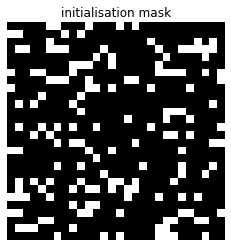

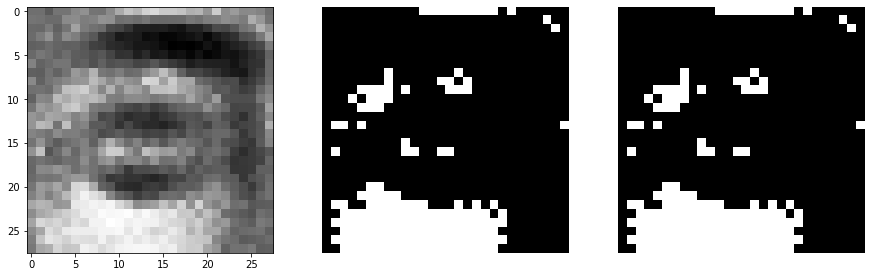

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.0338
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.0371
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.0406
test at the end of epoch

Test set: Avg. loss: 0.0532


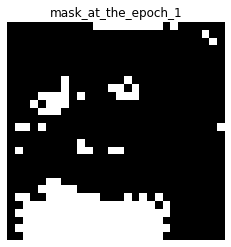

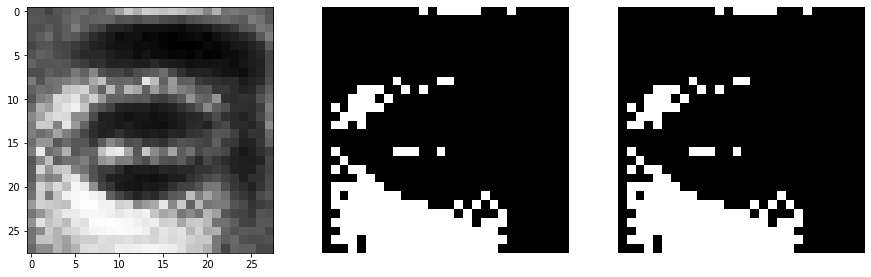

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.0446
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.0446
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.0516
test at the end of epoch

Test set: Avg. loss: 0.0533


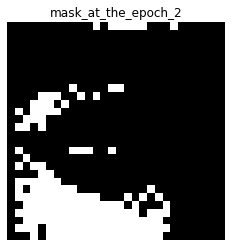

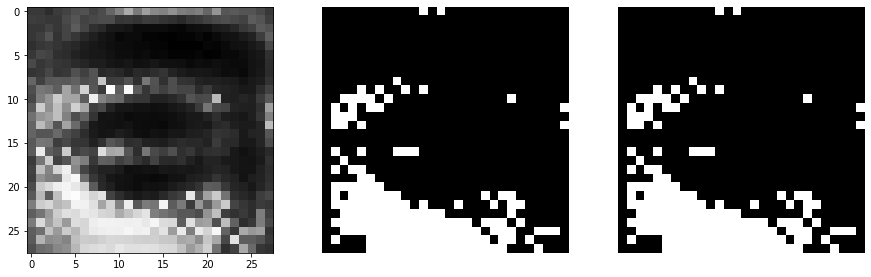

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.0511
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.0506
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.0536
test at the end of epoch

Test set: Avg. loss: 0.0544


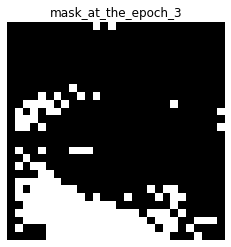

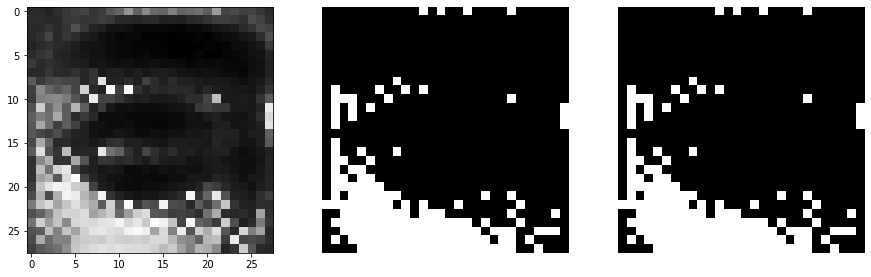

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.0542
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.0530
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.0528
test at the end of epoch

Test set: Avg. loss: 0.0528


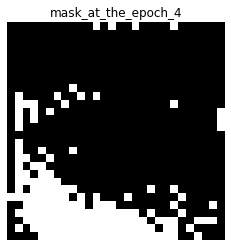

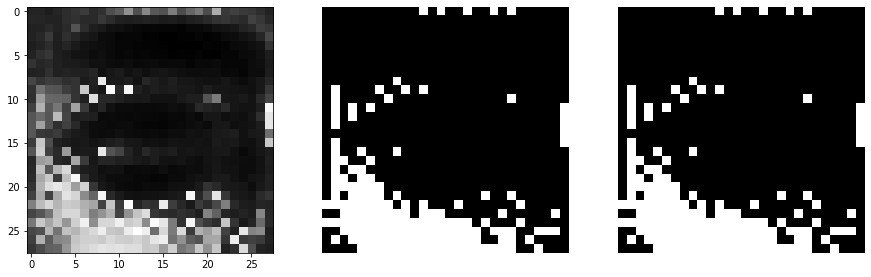

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.0535
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.0521
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.0519
test at the end of epoch

Test set: Avg. loss: 0.0527


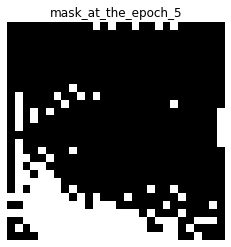

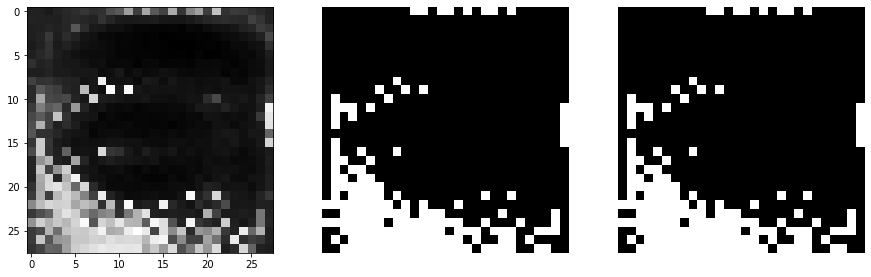

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.0531
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.0495
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.0549
test at the end of epoch

Test set: Avg. loss: 0.0524


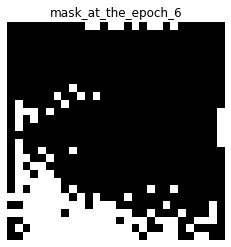

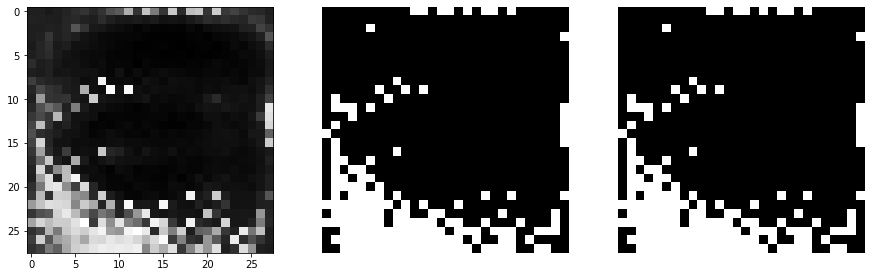

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.0538
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.0527
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.0556
test at the end of epoch

Test set: Avg. loss: 0.0524


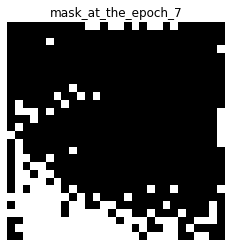

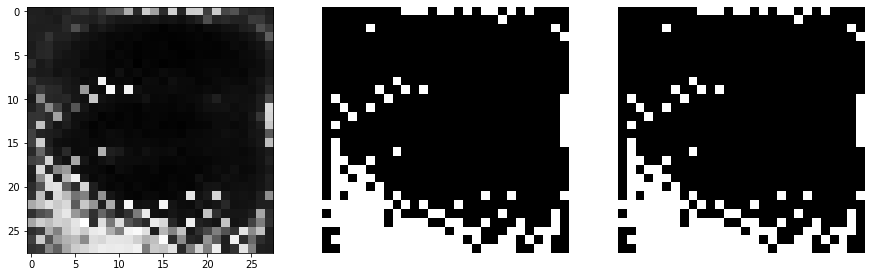

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.0513
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.0547
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.0520
test at the end of epoch

Test set: Avg. loss: 0.0521


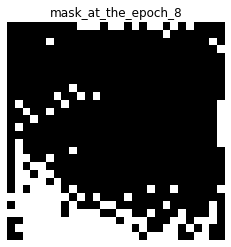

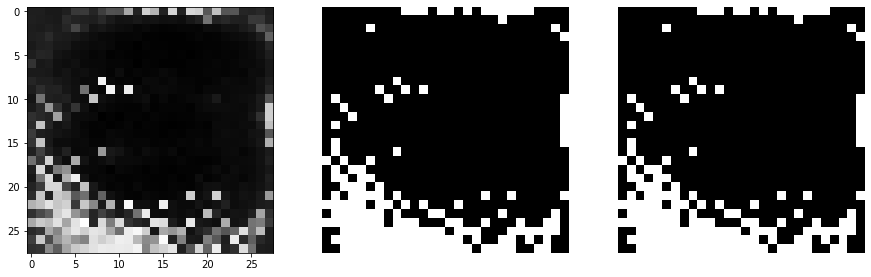

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.0534
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.0517
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.0530
test at the end of epoch

Test set: Avg. loss: 0.0522


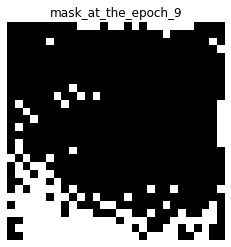

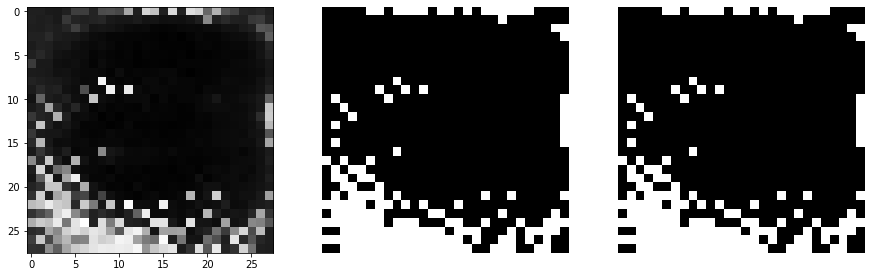

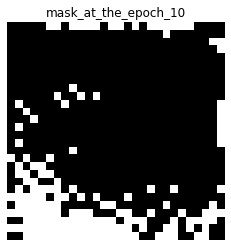

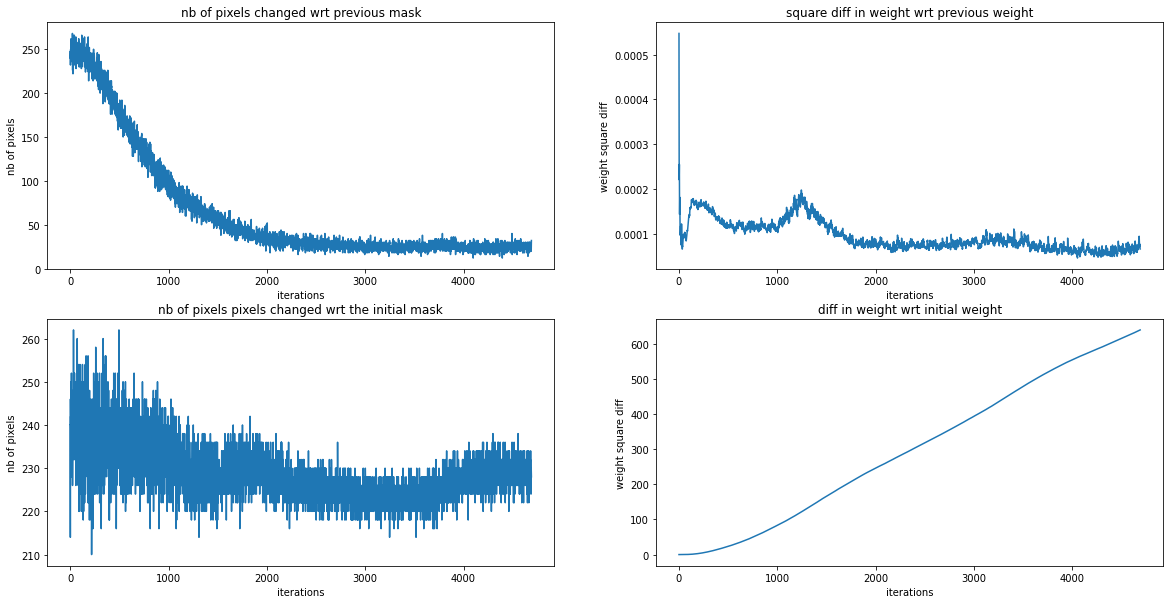

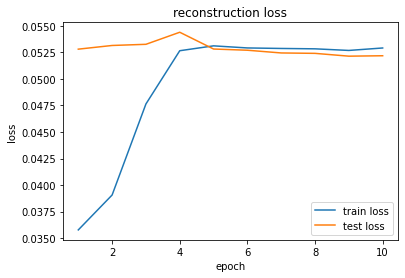

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Test set: Avg. loss: 0.0522


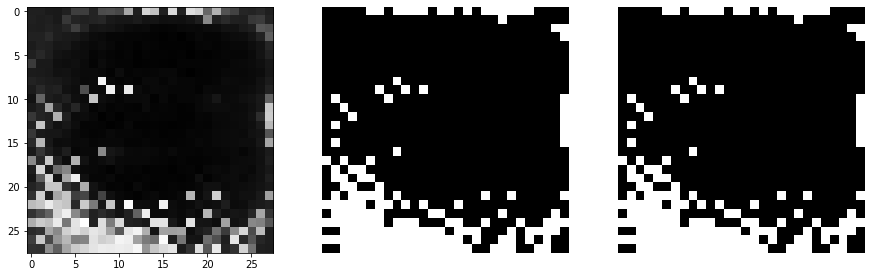

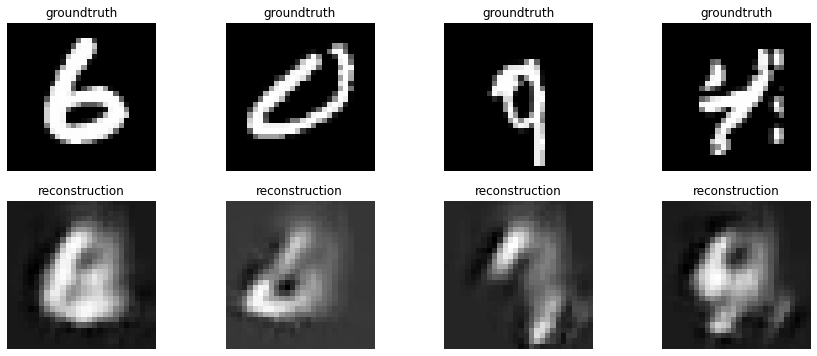

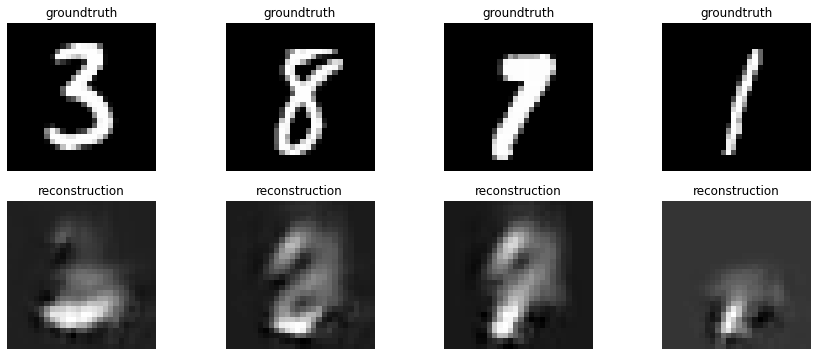

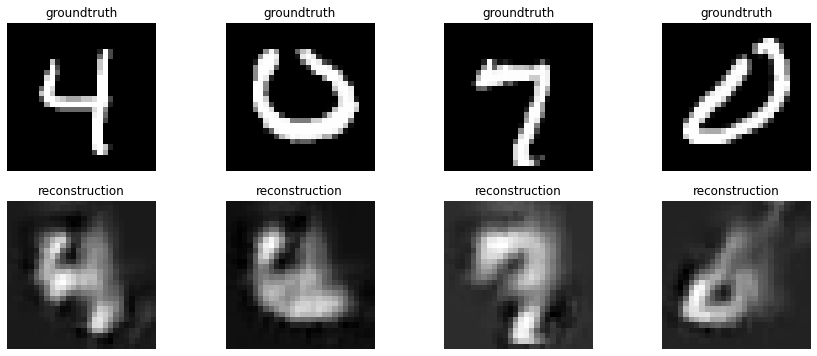

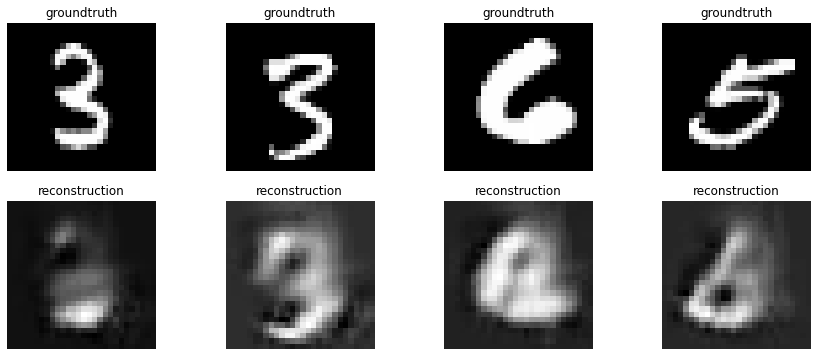

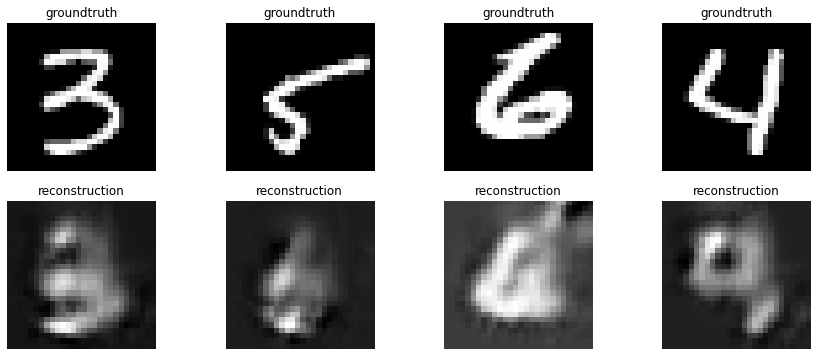

{'test_ssim': 0.5435543931103507, 'test_psnr': 14.504079936294747}


In [48]:
spirit_config_0 = {
    "batch_size": 128, 
    "kernel1": [5,5],
    "ncoils" : 1, 
    "nslices" : 1,
    "spirit_block" : 5,
    "std_noise": 0.05,
    "dropout_proba": 0.,
    "slice_dim" : (28,28),
    "multicoil": True,
    "mask_dim" : (28,28),
    "slope": 1,
    "complexe":False, ##because we are using image data
    "lr_mask": 1e-3,
    "lr_other": 1e-2,
    "spirit_activation": "none", ##activation function after spirit
    "batch_norm": False, #for bn_list
    "main_directory":".",
    "auxiliary":False, #no auxiliar reconstruction
    "weight_loss" :False,  #no weighted loss
    "acceleration": 0.2
}

model0 = run_model(spirit_config_0)

#################################################################
spirit_bloc : 5 ; batch_norm : False; std_noise : 0.05; lr_mask : 0.001; lr_other : 0.01
Number of acquired points in the whole mask : 156
Number of acquired points in the local mask of size [5, 5] : 5
stackSpirit


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.0936
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.0226
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.0215
test at the end of epoch

Test set: Avg. loss: 0.0177


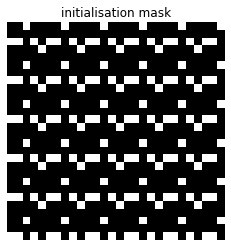

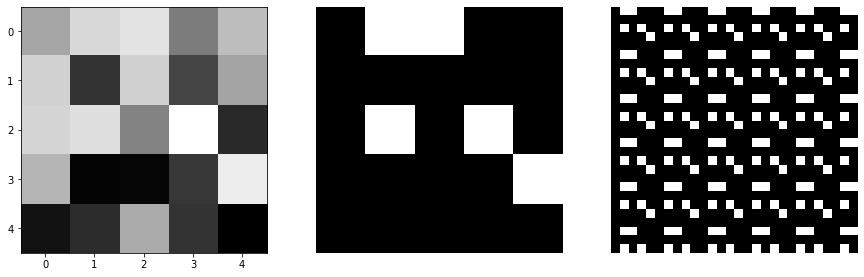

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.0215
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.0225
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.0207
test at the end of epoch

Test set: Avg. loss: 0.0203


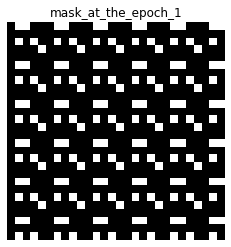

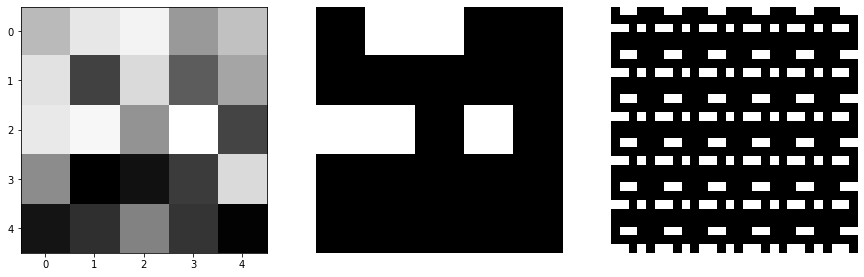

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.0207
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.0211
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.0214
test at the end of epoch

Test set: Avg. loss: 0.0206


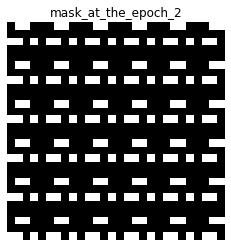

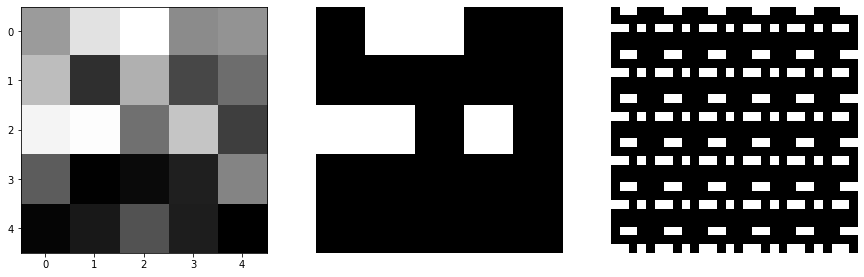

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.0223
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.0215
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.0229
test at the end of epoch

Test set: Avg. loss: 0.0239


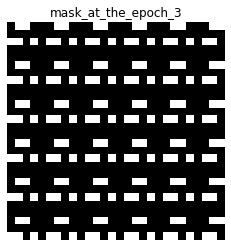

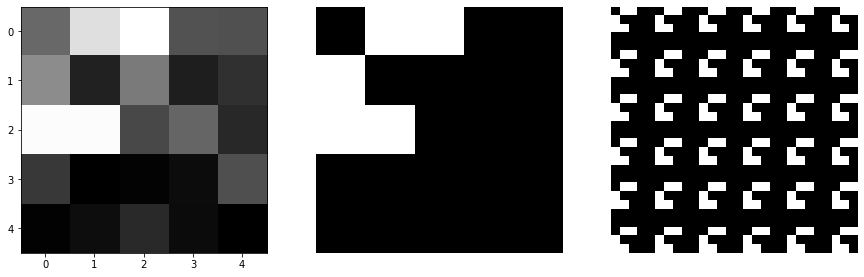

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.0239
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.0239
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.0240
test at the end of epoch

Test set: Avg. loss: 0.0231


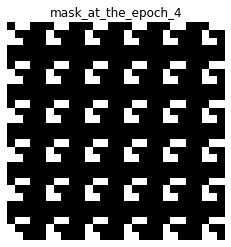

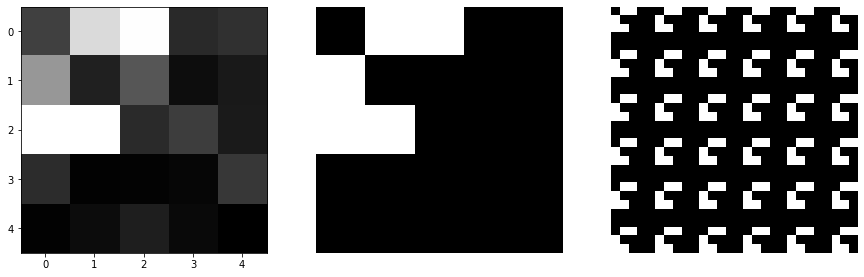

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.0236
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.0256
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.0241
test at the end of epoch

Test set: Avg. loss: 0.0235


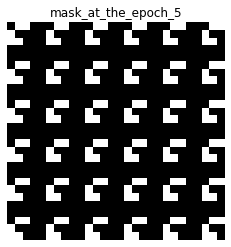

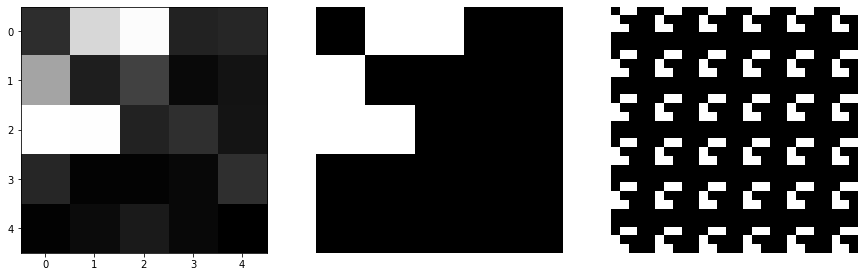

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.0232
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.0243
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.0235
test at the end of epoch

Test set: Avg. loss: 0.0226


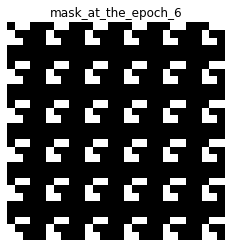

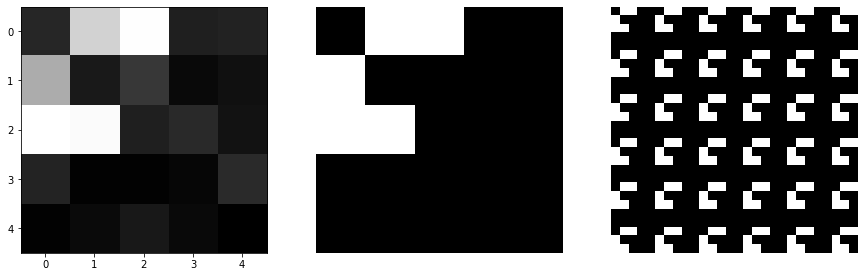

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.0242
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.0227
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.0223
test at the end of epoch

Test set: Avg. loss: 0.0226


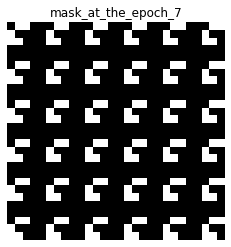

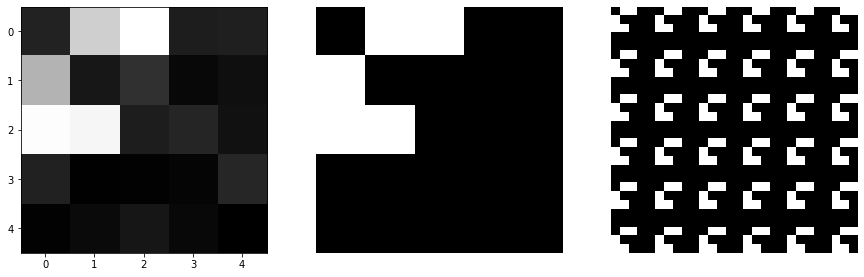

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.0219
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.0235
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.0232
test at the end of epoch

Test set: Avg. loss: 0.0227


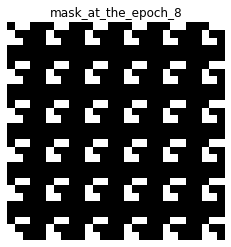

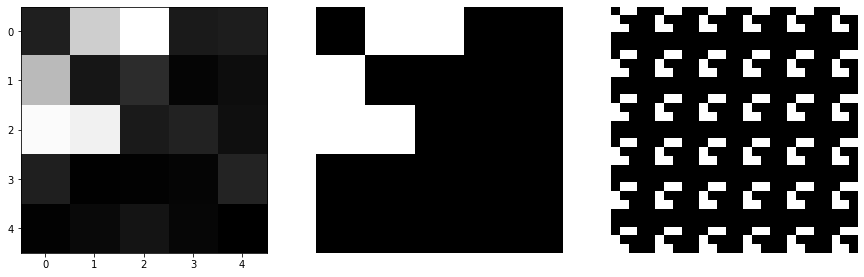

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.0231
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.0229
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.0244
test at the end of epoch

Test set: Avg. loss: 0.0226


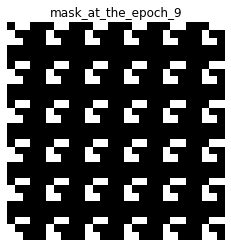

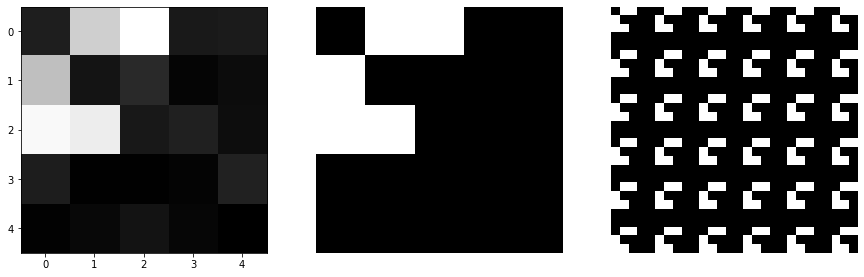

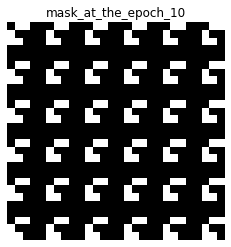

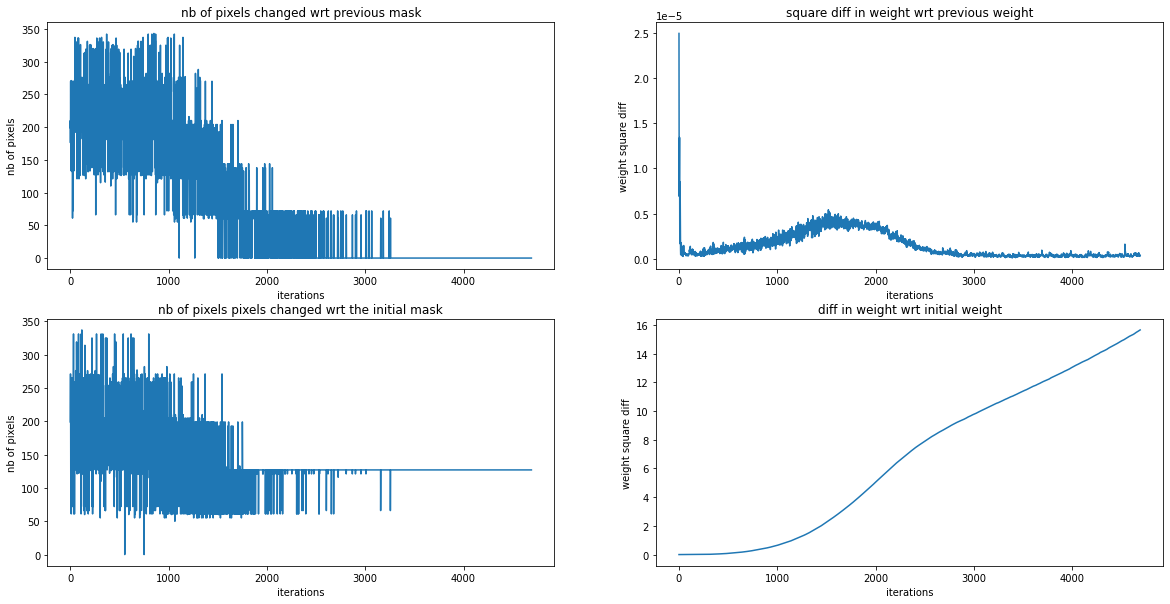

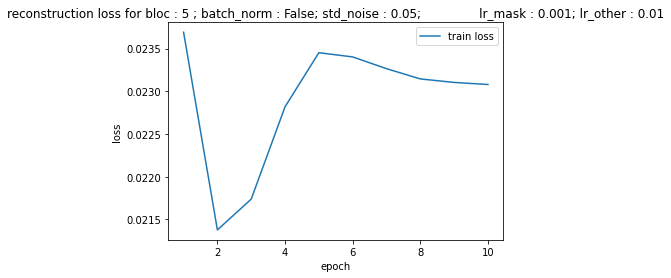

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Test set: Avg. loss: 0.0226


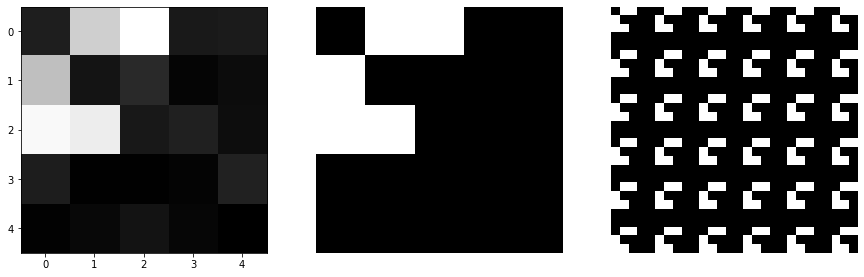

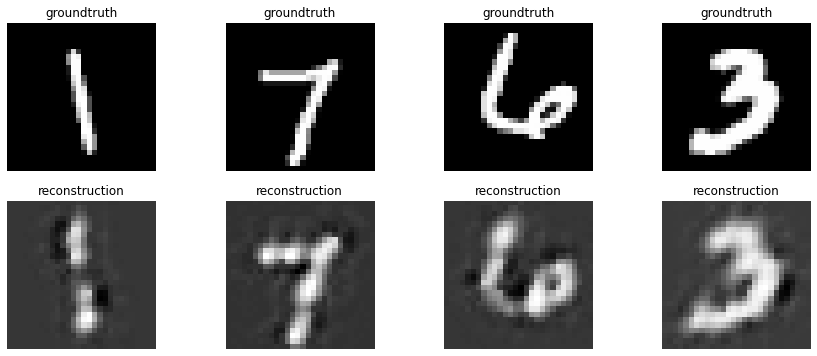

average ssim and psnr on test set {'test_ssim': 0.7817019093819191, 'test_psnr': 18.284999052601588}
##########   FIN   ##########


In [49]:
##let us use local mask and use the grid search function
spirit_config_0_bis = {
    "batch_size": 128, 
    "kernel1": [5,5],
    "ncoils" : 1, 
    "nslices" : 1,
    "spirit_block" : 5,
    "std_noise": 0.05,
    "dropout_proba": 0.,
    "slice_dim" : (28,28),
    "multicoil": False,
    "mask_dim" : (5,5),
    "slope": 1,
    "complexe":False,
    "lr_mask": 1e-3,
    "lr_other": 1e-2,
    "spirit_activation": "none", ##activation function after spirit
    "batch_norm": False, #for bn_list
    "main_directory":".",
    "auxiliary":False,
    "weight_loss" :False,
    "acceleration": 0.2
}

model0_bis = make_grid_search_4(spirit_config_0_bis, spirit_block_list=[5], std_noise_list=[0.05], bn_list=[False], lr_mask_list=[1e-3], lr_other_list=[1e-2], critere = nn.MSELoss(), return_model =True )


 
## <font color='darkblue'> multicoil image , no weighted loss , no auxiliary</font>


Number of acquired points in the whole mask : 156
Number of acquired points in the local mask of size [28, 28] : 156
stackSpirit


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.0996
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.0317
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.0350
test at the end of epoch

Test set: Avg. loss: 0.0561


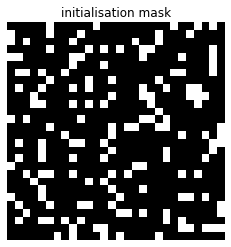

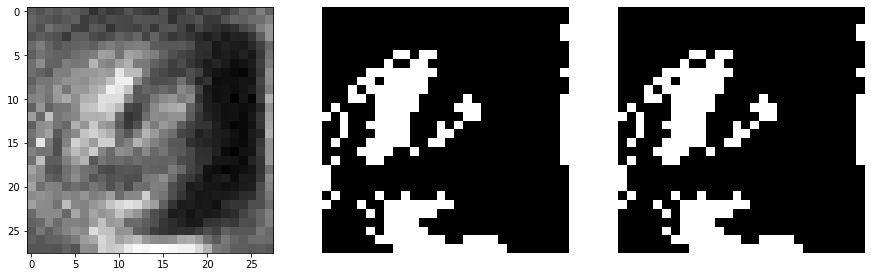

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.0366
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.0409
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.0477
test at the end of epoch

Test set: Avg. loss: 0.0545


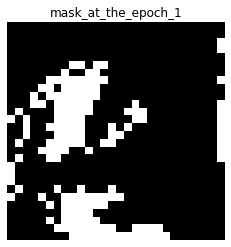

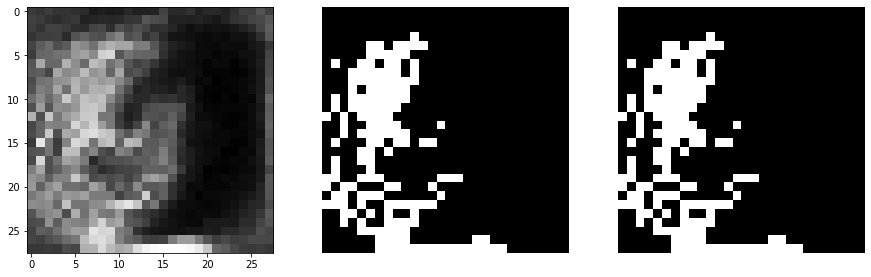

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.0469
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.0490
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.0505
test at the end of epoch

Test set: Avg. loss: 0.0598


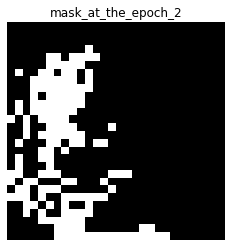

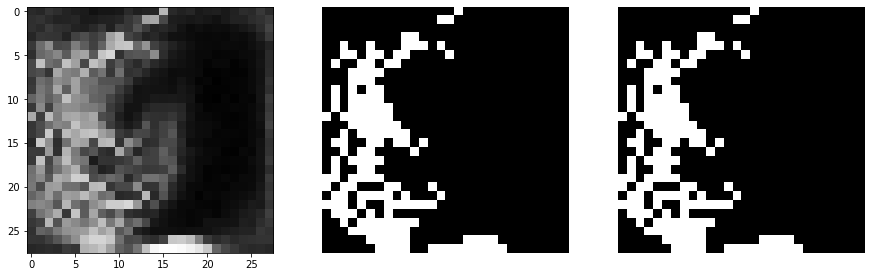

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.0510
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.0504
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.0490
test at the end of epoch

Test set: Avg. loss: 0.0495


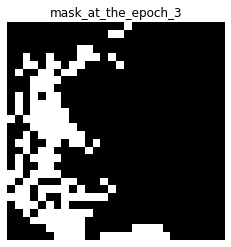

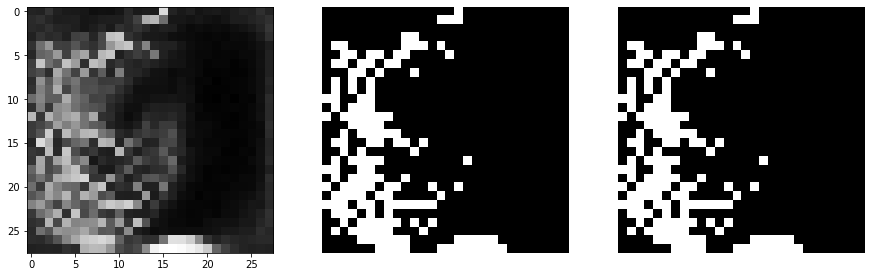

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.0500
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.0469
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.0489
test at the end of epoch

Test set: Avg. loss: 0.0477


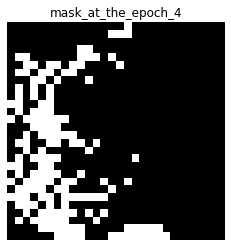

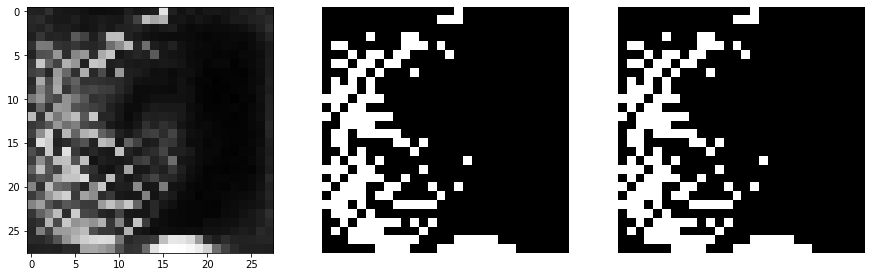

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.0468
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.0503
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.0490
test at the end of epoch

Test set: Avg. loss: 0.0476


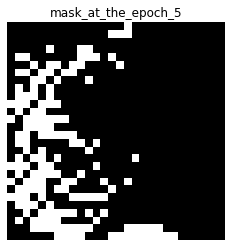

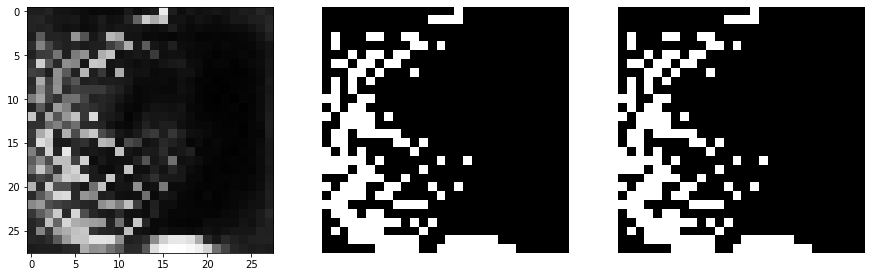

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.0490
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.0466
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.0486
test at the end of epoch

Test set: Avg. loss: 0.0499


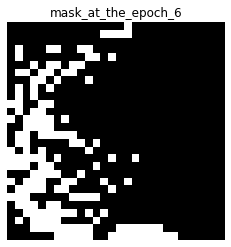

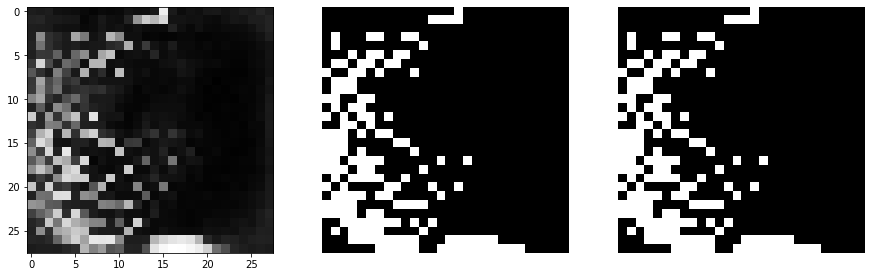

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.0504
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.0460
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.0475
test at the end of epoch

Test set: Avg. loss: 0.0455


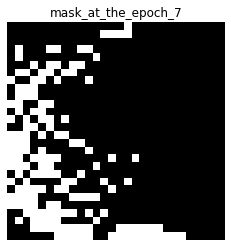

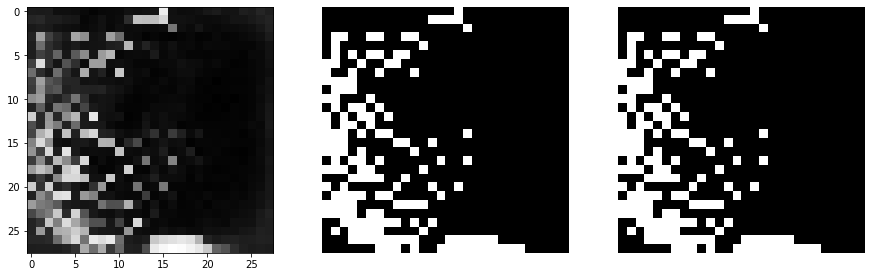

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.0506
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.0493
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.0469
test at the end of epoch

Test set: Avg. loss: 0.0451


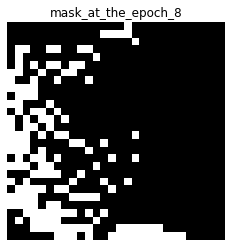

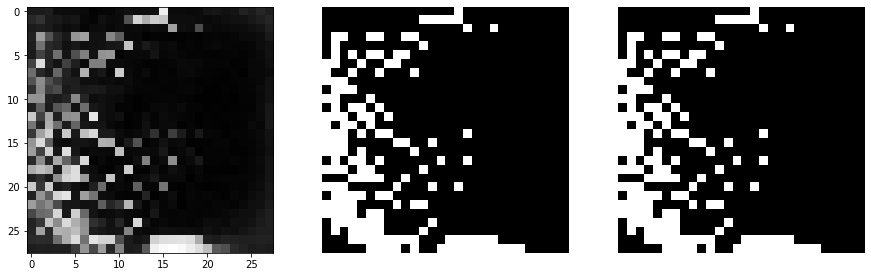

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.0474
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.0464
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.0465
test at the end of epoch

Test set: Avg. loss: 0.0452


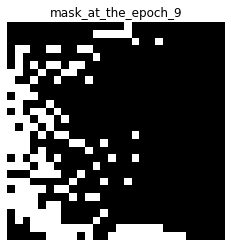

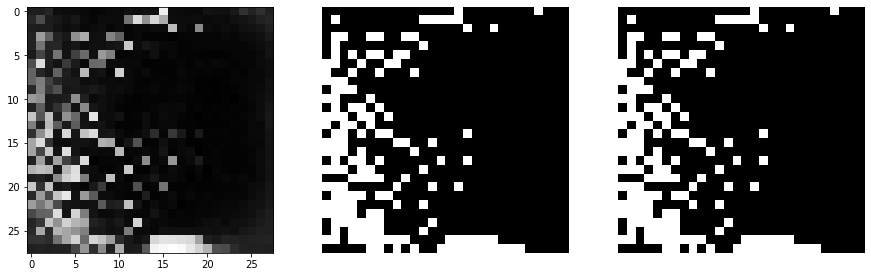

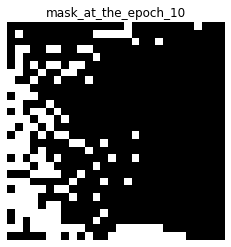

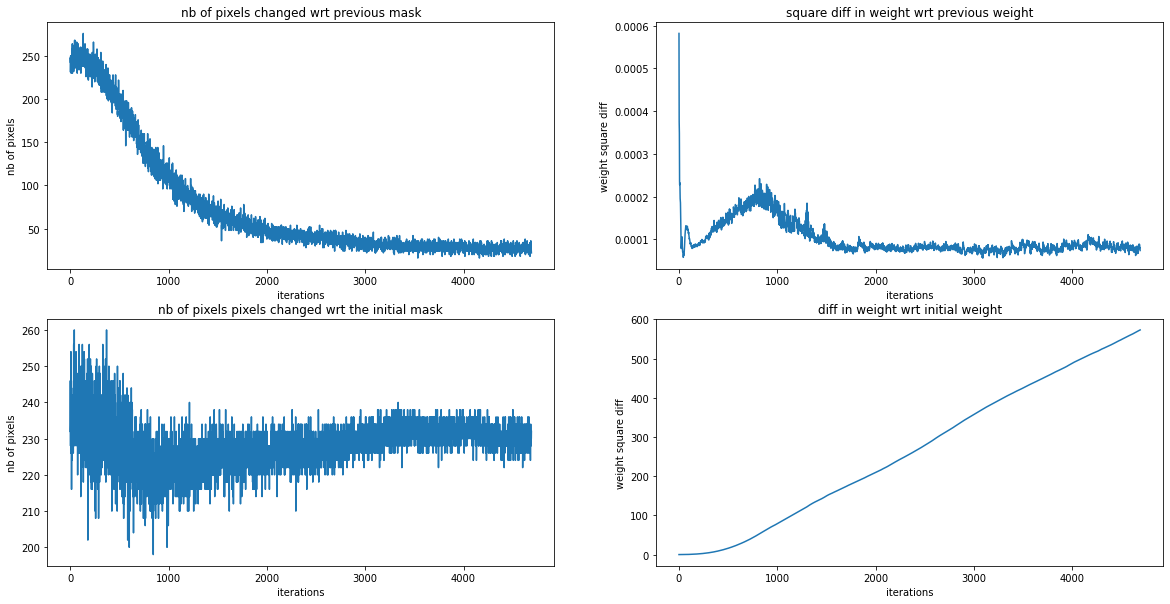

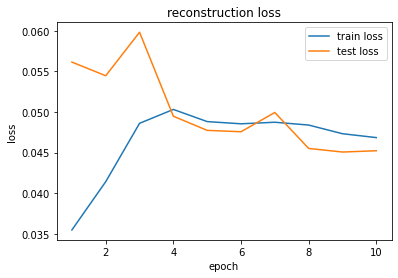

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Test set: Avg. loss: 0.0452


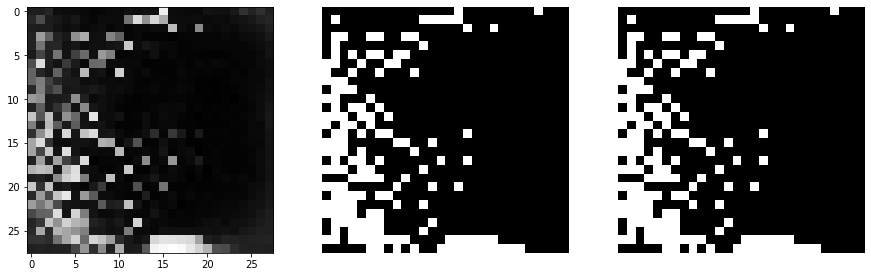

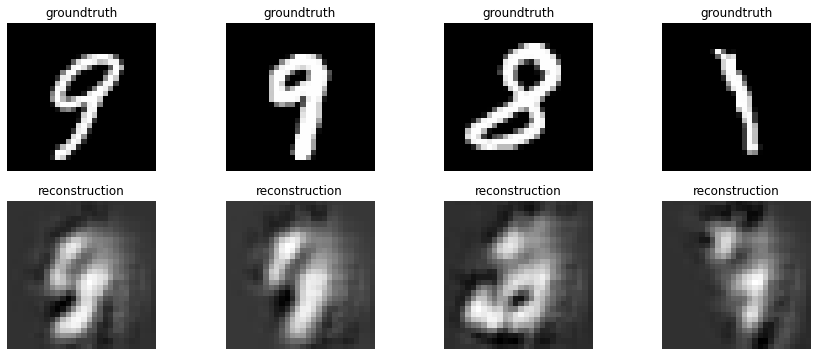

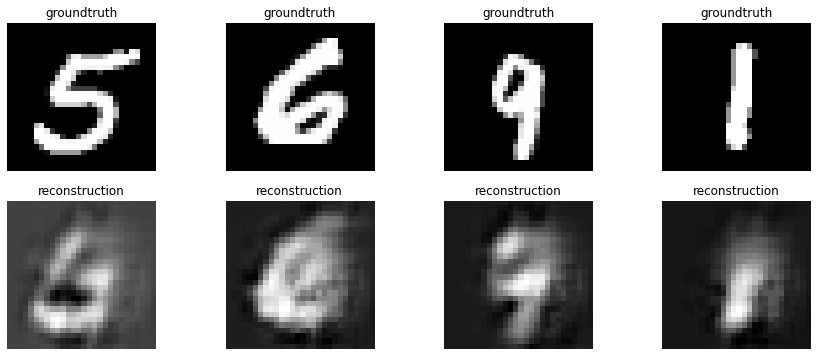

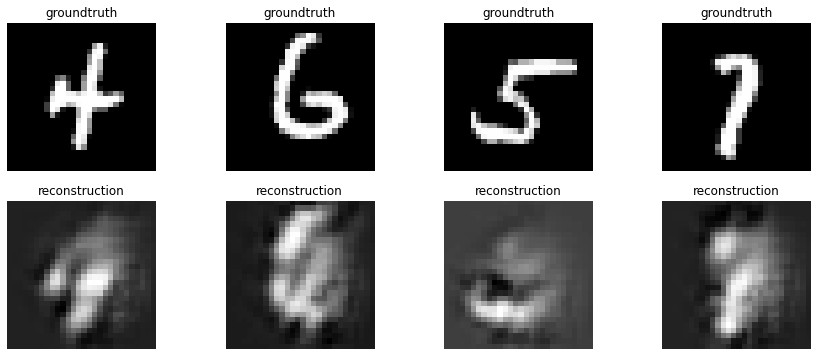

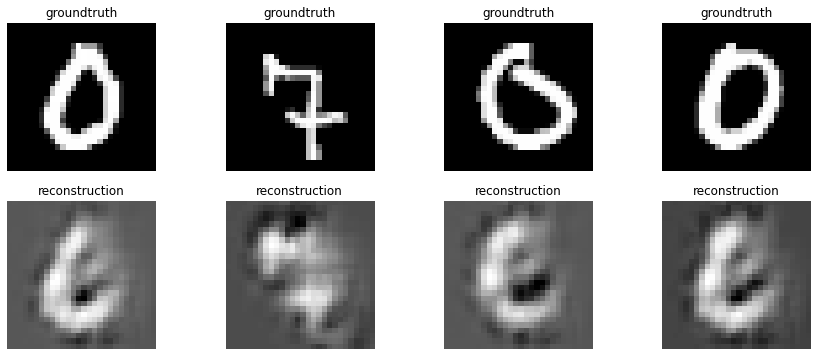

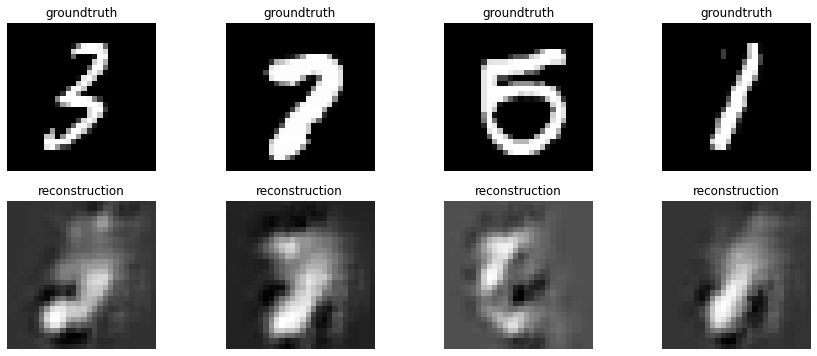

{'test_ssim': 0.503922947777205, 'test_psnr': 14.357239924595241}


In [50]:
spirit_config_1 = {
    "batch_size": 128, 
    "kernel1": [5,5],
    "ncoils" : 1, 
    "nslices" : 8,
    "spirit_block" : 5,
    "std_noise": 0.05,
    "dropout_proba": 0.,
    "slice_dim" : (28,28),
    "multicoil": True,
    "mask_dim" : (28,28),
    "slope": 1,
    "complexe":False,
    "lr_mask": 1e-3,
    "lr_other": 1e-2,
    "spirit_activation": "none", ##activation function after spirit
    "batch_norm": False, #for bn_list
    "main_directory":".",
    "auxiliary":False,
    "weight_loss" :False,
    "acceleration": 0.2
}

spirit_config_1 =edict(spirit_config_1)
 
model1= run_model(spirit_config_1)

 
## <font color='darkblue'> multicoil fft image (ffit image + sensitivity coils)</font>


Number of acquired points in the whole mask : 156
Number of acquired points in the local mask of size [28, 28] : 156
ComplexstackSpirit


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")




Train Epoch: 1 [0/60000 (0%)]	Loss: 44.4244








































































































































































































Train Epoch: 1 [25600/60000 (43%)]	Loss: 3.4372








































































































































































































Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.3119




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 2.0970


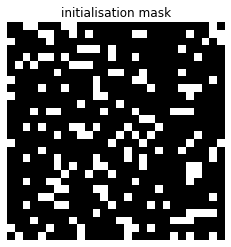

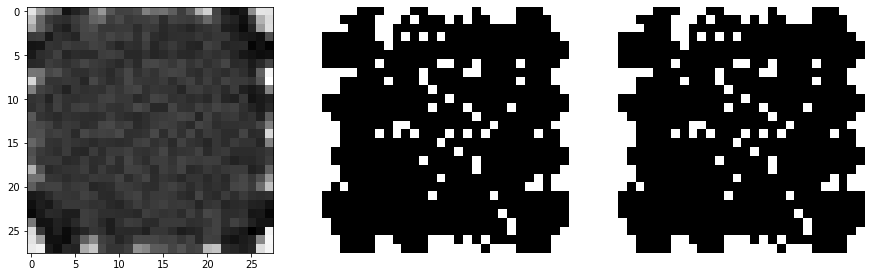


Train Epoch: 2 [0/60000 (0%)]	Loss: 2.1069








































































































































































































Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.8323








































































































































































































Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.6612




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 1.6065


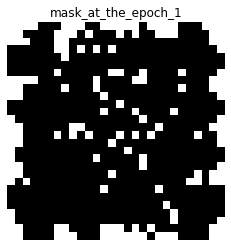

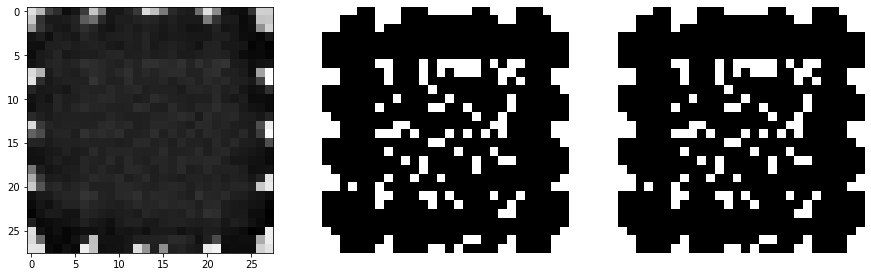


Train Epoch: 3 [0/60000 (0%)]	Loss: 1.4022








































































































































































































Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.4541








































































































































































































Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.5116




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 1.3725


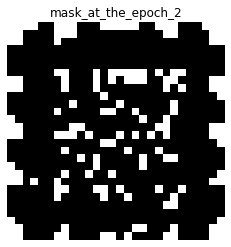

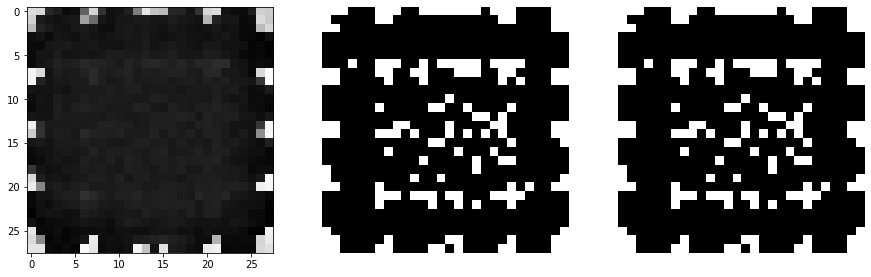


Train Epoch: 4 [0/60000 (0%)]	Loss: 1.4313








































































































































































































Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.3018








































































































































































































Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.3989




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 1.3089


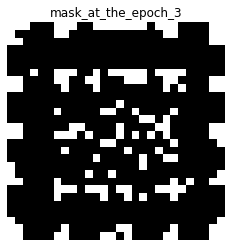

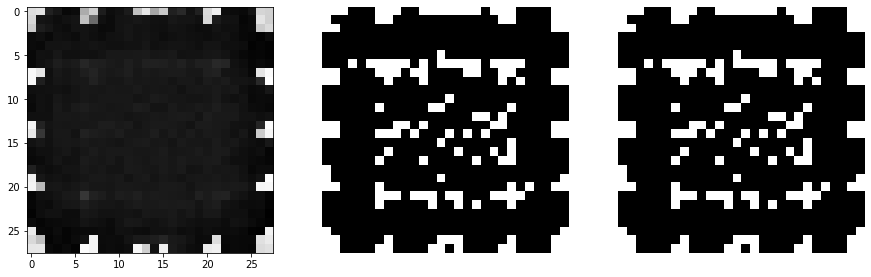


Train Epoch: 5 [0/60000 (0%)]	Loss: 1.3653








































































































































































































Train Epoch: 5 [25600/60000 (43%)]	Loss: 1.3245








































































































































































































Train Epoch: 5 [51200/60000 (85%)]	Loss: 1.3075




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 1.3668


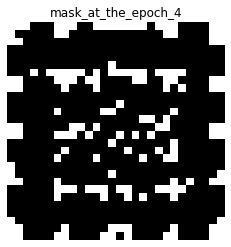

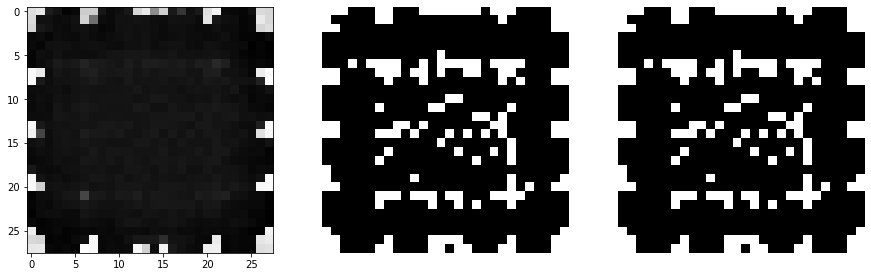


Train Epoch: 6 [0/60000 (0%)]	Loss: 1.4081








































































































































































































Train Epoch: 6 [25600/60000 (43%)]	Loss: 1.2718








































































































































































































Train Epoch: 6 [51200/60000 (85%)]	Loss: 1.3673




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 1.2973


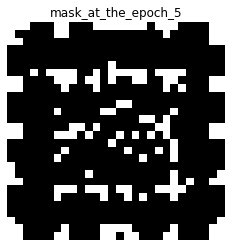

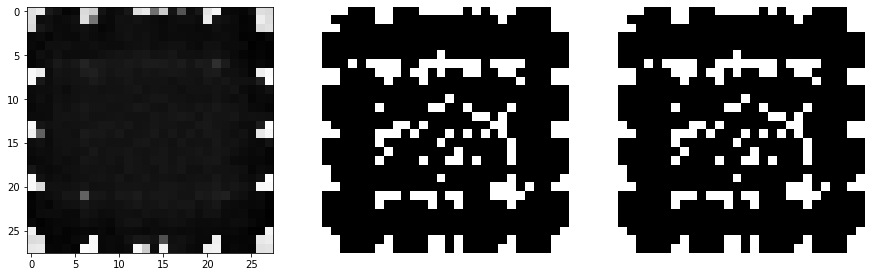


Train Epoch: 7 [0/60000 (0%)]	Loss: 1.3947








































































































































































































Train Epoch: 7 [25600/60000 (43%)]	Loss: 1.3885








































































































































































































Train Epoch: 7 [51200/60000 (85%)]	Loss: 1.3200




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 1.3256


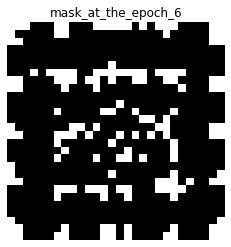

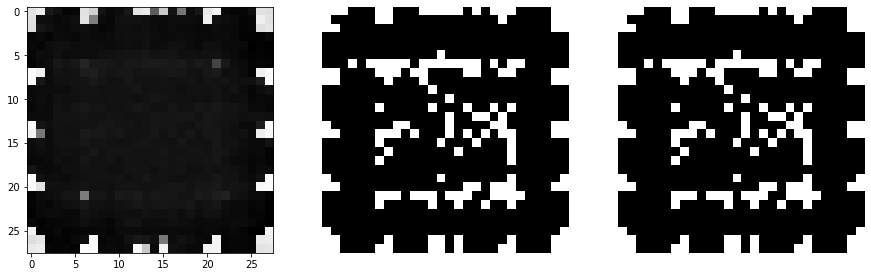


Train Epoch: 8 [0/60000 (0%)]	Loss: 1.3177








































































































































































































Train Epoch: 8 [25600/60000 (43%)]	Loss: 1.3905








































































































































































































Train Epoch: 8 [51200/60000 (85%)]	Loss: 1.3281




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 1.4762


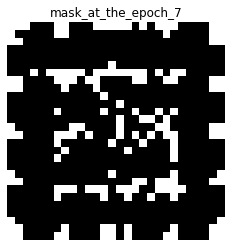

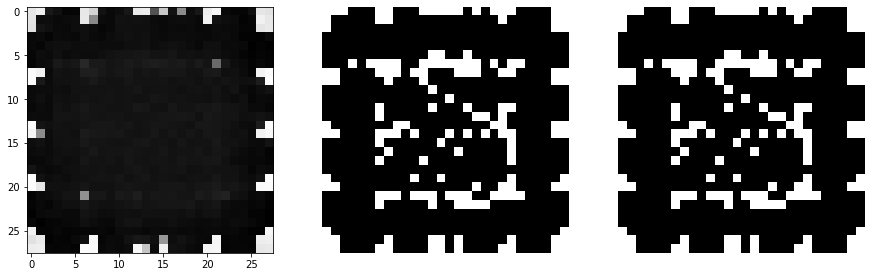


Train Epoch: 9 [0/60000 (0%)]	Loss: 1.4184








































































































































































































Train Epoch: 9 [25600/60000 (43%)]	Loss: 1.3163








































































































































































































Train Epoch: 9 [51200/60000 (85%)]	Loss: 1.2431




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 1.4717


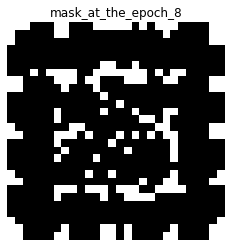

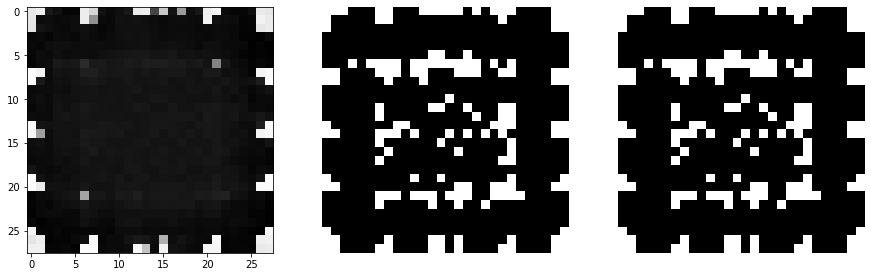


Train Epoch: 10 [0/60000 (0%)]	Loss: 1.3084








































































































































































































Train Epoch: 10 [25600/60000 (43%)]	Loss: 1.3152








































































































































































































Train Epoch: 10 [51200/60000 (85%)]	Loss: 1.3748




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 1.4809


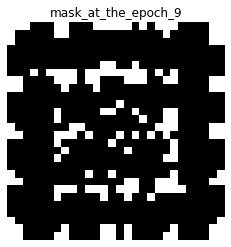

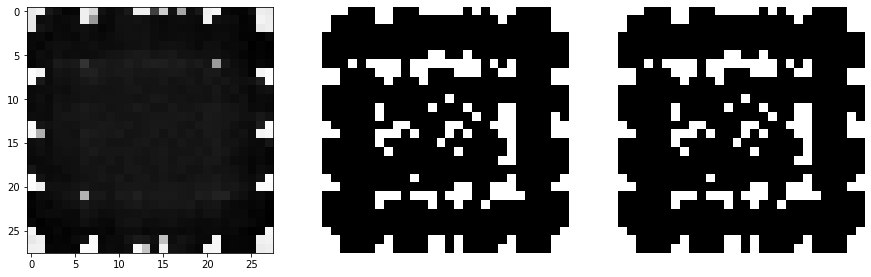

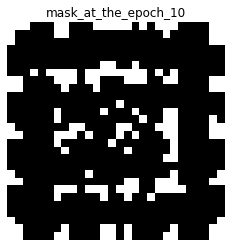

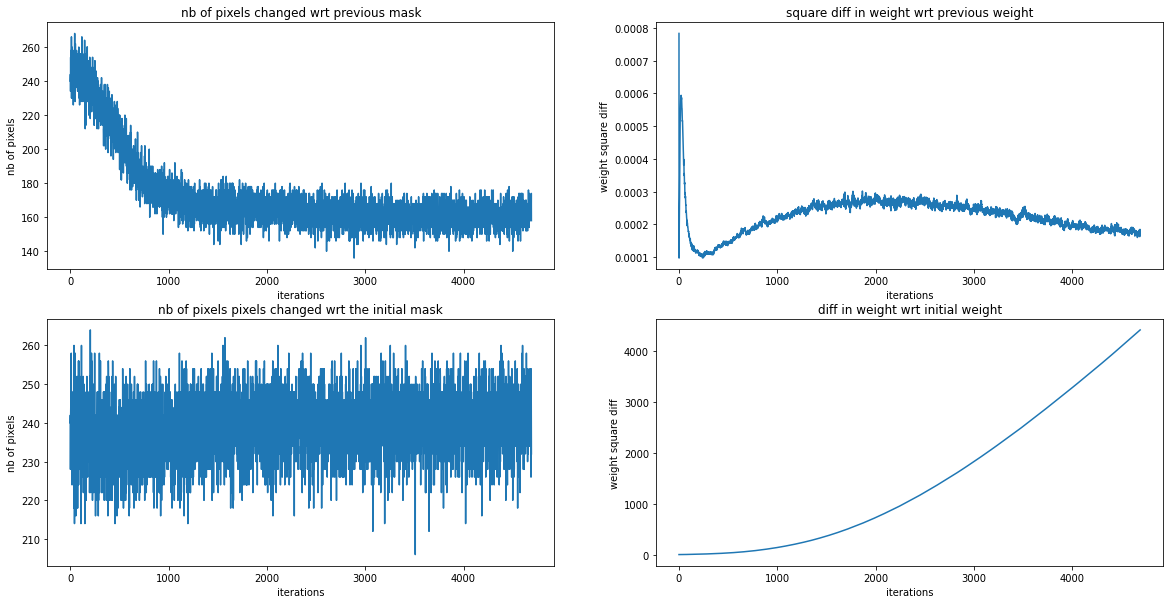

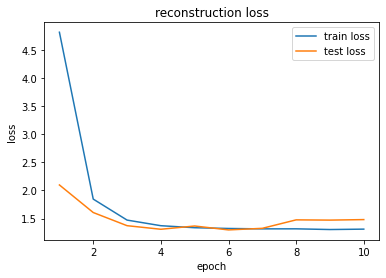

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")










































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 1.4809


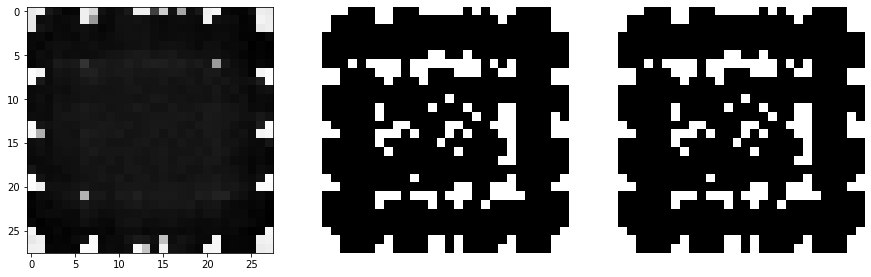

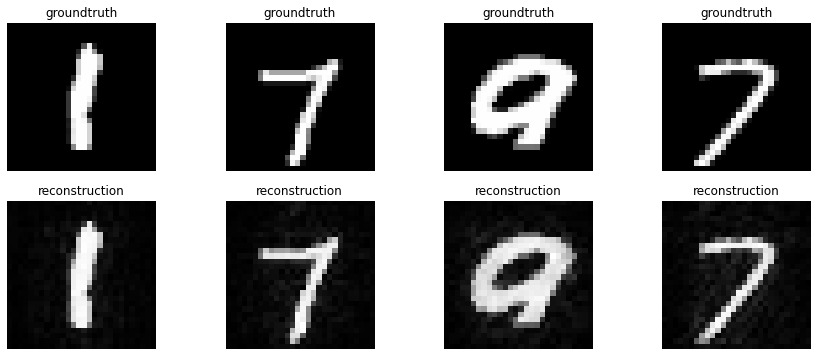

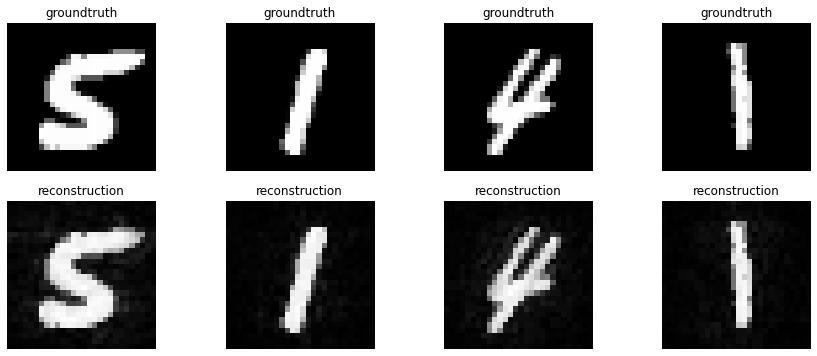

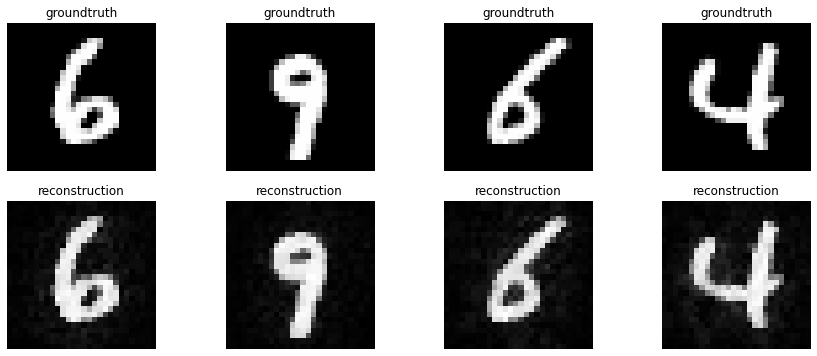

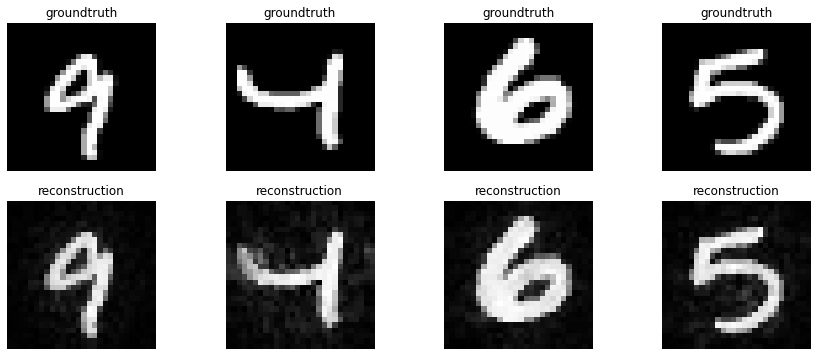

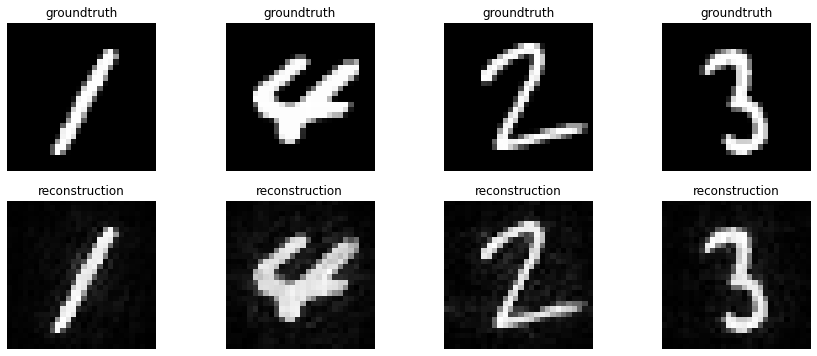

{'test_ssim': 0.861273224683961, 'test_psnr': 23.579202697440277}


In [53]:
##usage de new net
spirit_config_2 = {
    "batch_size": 128, 
    "kernel1": [5,5],
    "ncoils" : 8, 
    "nslices" : 1,
    "spirit_block" : 5,
    "std_noise": 0.05,
    "dropout_proba": 0.,
    "slice_dim" : (28,28),
    "multicoil": True,
    "mask_dim" : (28,28),
    "slope": 1,
    "complexe":True,
    "lr_mask": 1e-3,
    "lr_other": 1e-2,
    "spirit_activation": "none", ##activation function after spirit
    "batch_norm": False, #for bn_list
    "main_directory":".",
    "auxiliary":False,
    "weight_loss" :False,
    "acceleration": 0.2
}

spirit_config_2 =edict(spirit_config_2)

model2= run_model(spirit_config_2)


à revoir, normalement c'est le "multicoil image" qui donne ces résultats

 
## <font color='darkblue'> no multicoil, image, no sensitivity, weighted cost function, no auxiliary loss </font>


Number of acquired points in the whole mask : 156
Number of acquired points in the local mask of size [28, 28] : 156
stackSpirit


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.2763
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.0850
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.0782
test at the end of epoch

Test set: Avg. loss: 0.0858


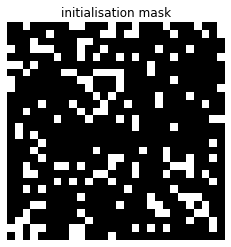

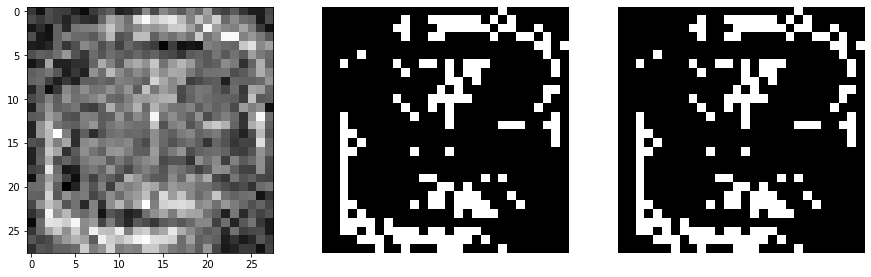

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.0794
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.0671
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.0662
test at the end of epoch

Test set: Avg. loss: 0.1199


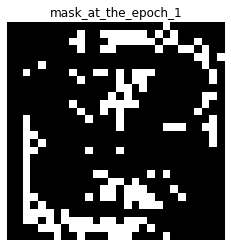

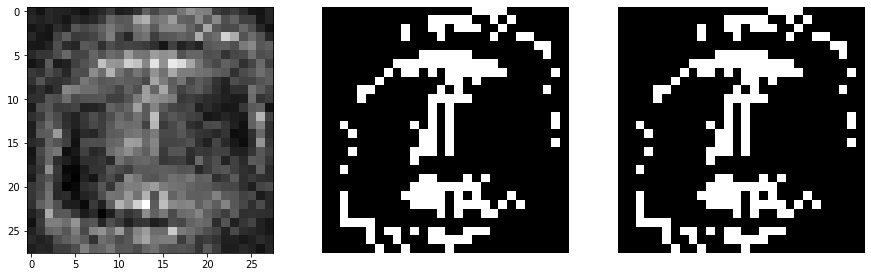

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.0705
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.0736
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.0773
test at the end of epoch

Test set: Avg. loss: 0.0186


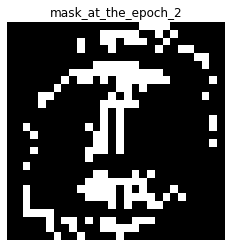

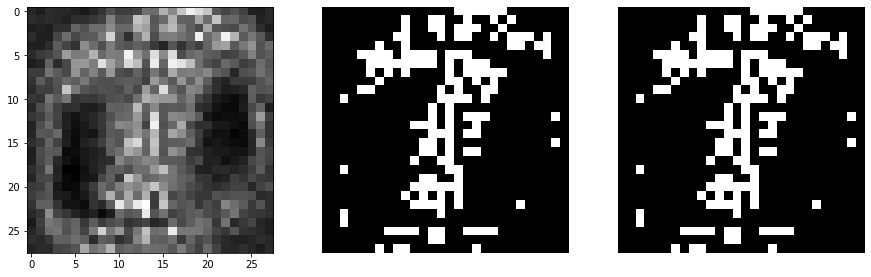

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.0719
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.0789
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.0798
test at the end of epoch

Test set: Avg. loss: 0.0729


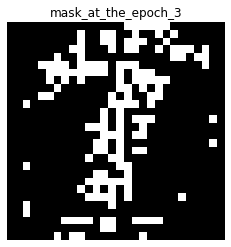

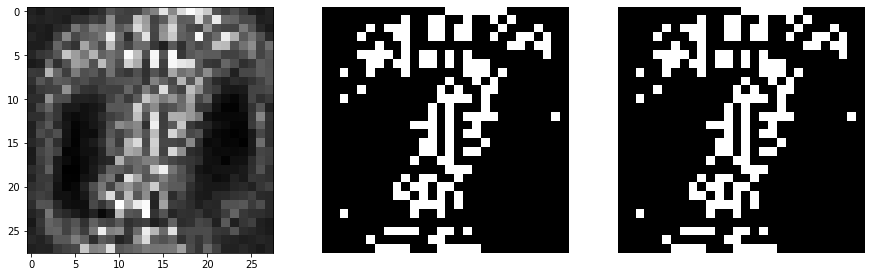

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.0803
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.0819
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.0803
test at the end of epoch

Test set: Avg. loss: 0.0246


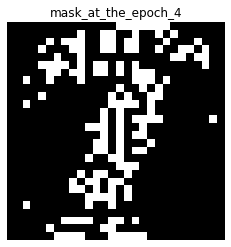

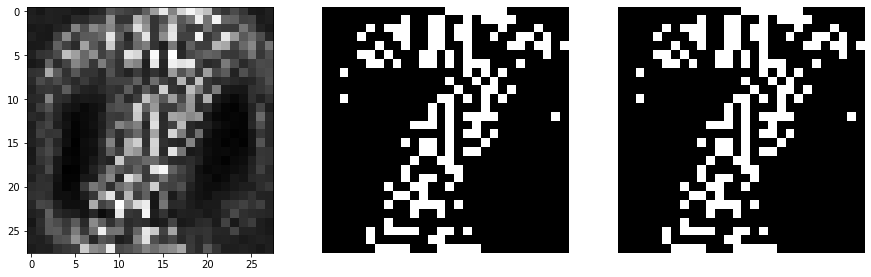

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.0718
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.0814
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.0796
test at the end of epoch

Test set: Avg. loss: 0.0540


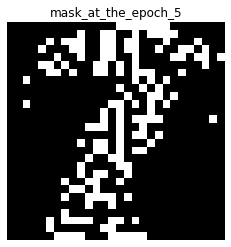

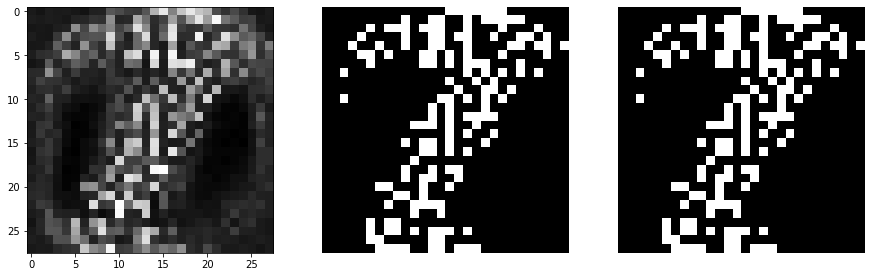

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.0758
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.0795
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.0901
test at the end of epoch

Test set: Avg. loss: 0.0054


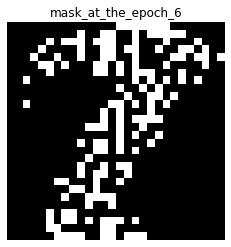

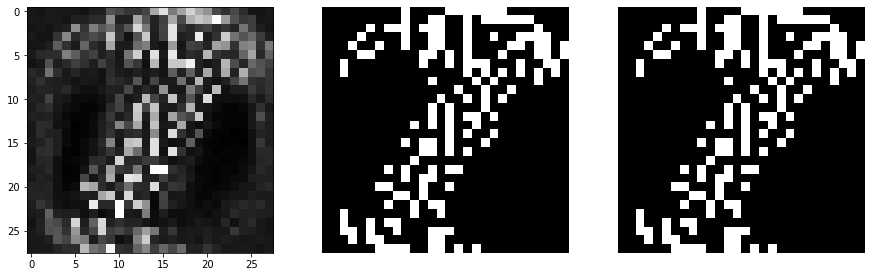

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.0850
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.0827
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.0822
test at the end of epoch

Test set: Avg. loss: 0.0335


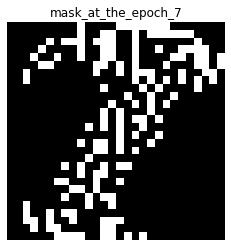

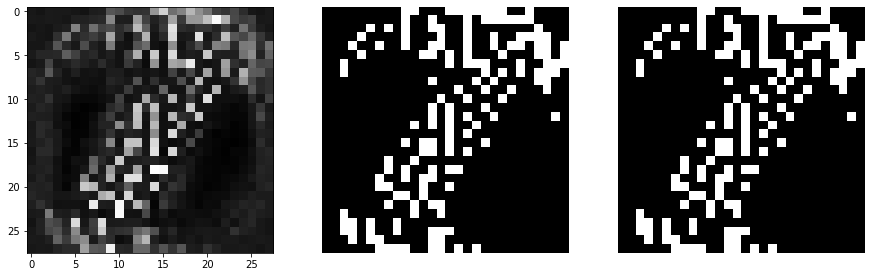

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.0863
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.0788
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.0938
test at the end of epoch

Test set: Avg. loss: 0.0741


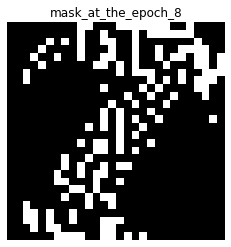

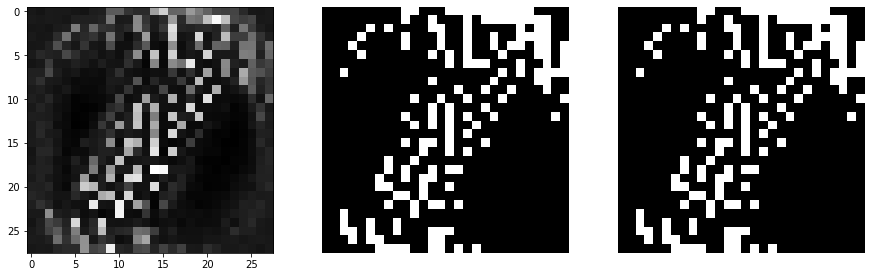

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.0866
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.0773
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.0810
test at the end of epoch

Test set: Avg. loss: 0.0435


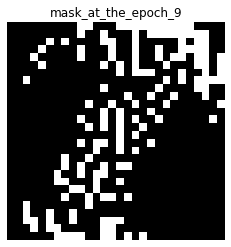

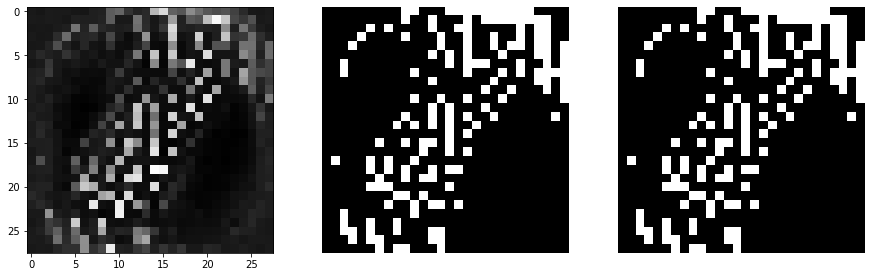

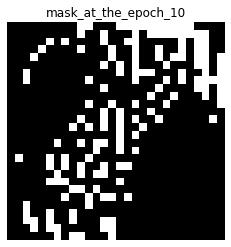

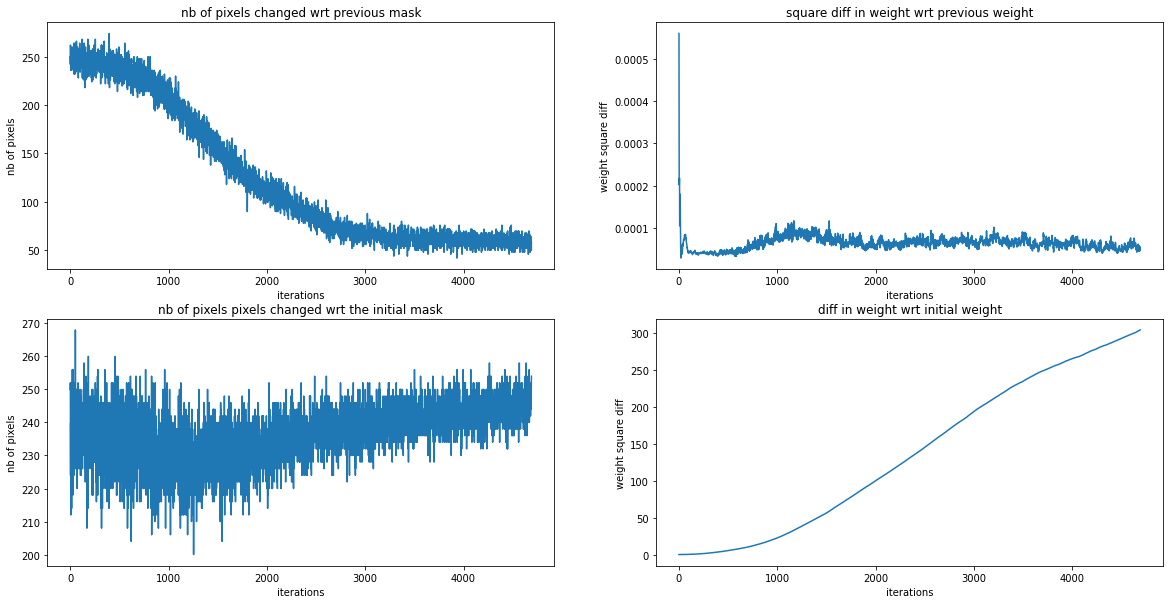

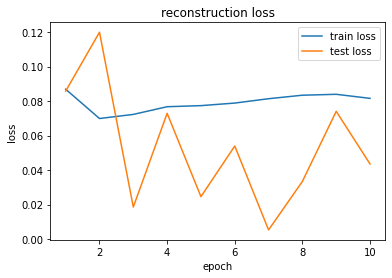

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Test set: Avg. loss: 0.0188


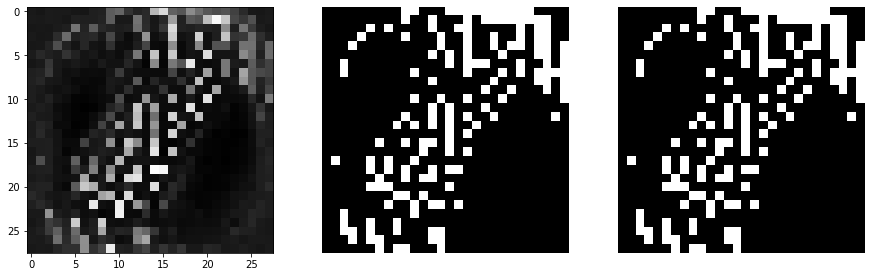

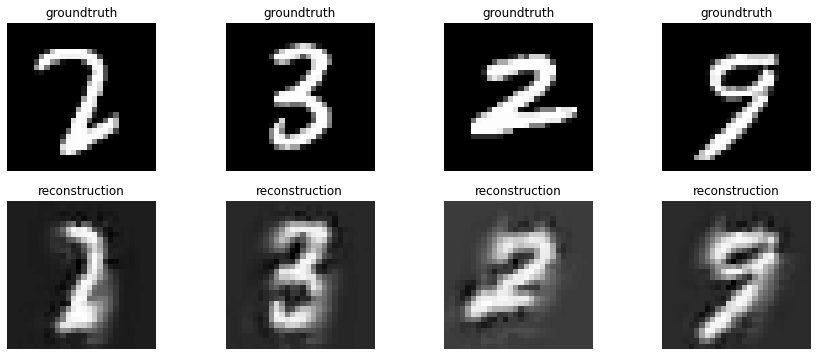

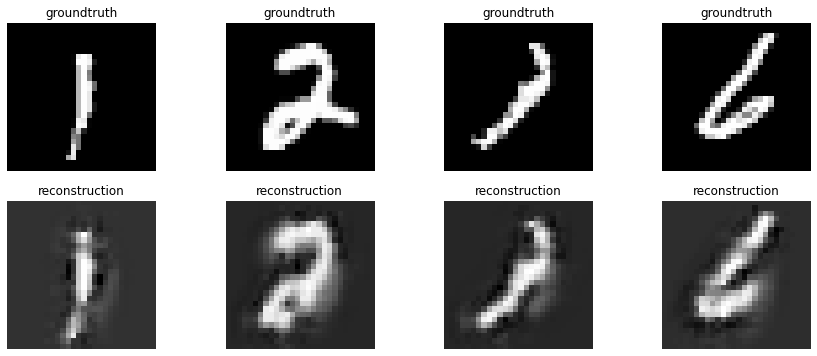

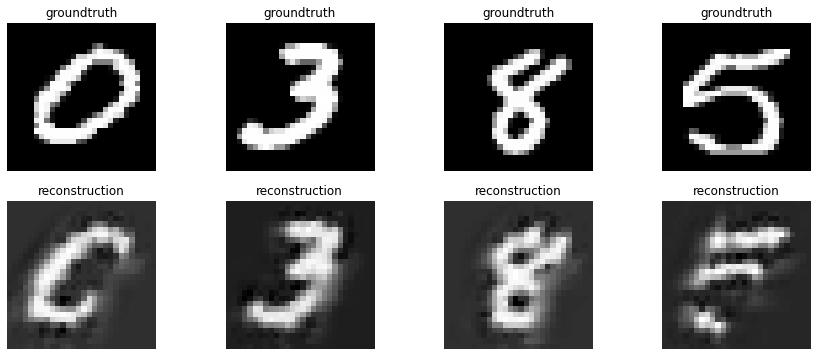

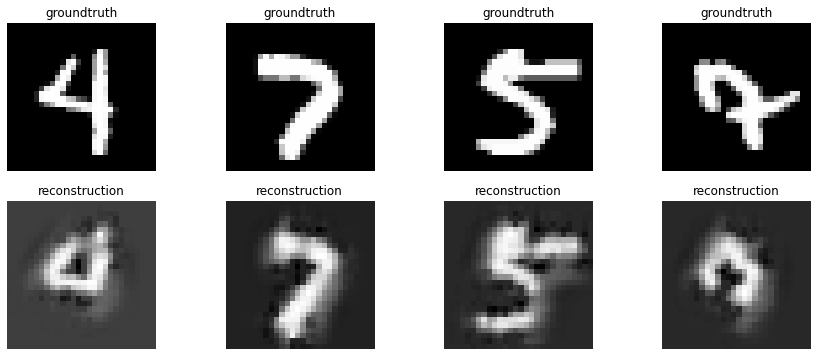

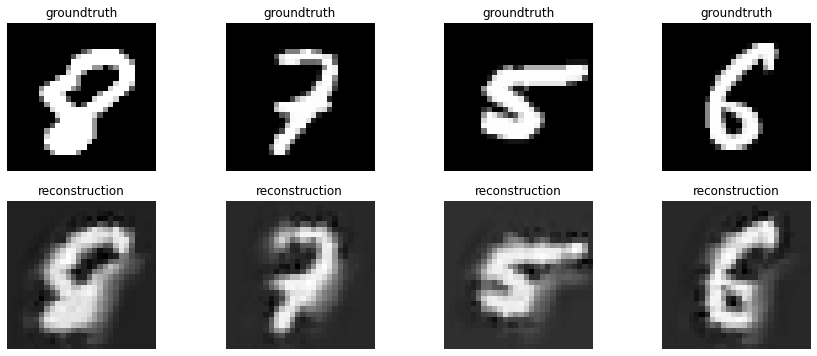

{'test_ssim': 0.6259418734166243, 'test_psnr': 14.28719270568804}


In [60]:
spirit_config_3 = {
    "batch_size": 128, 
    "kernel1": [5,5],
    "ncoils" : 1, 
    "nslices" : 1,
    "spirit_block" : 5,
    "std_noise": 0.05,
    "dropout_proba": 0.,
    "slice_dim" : (28,28),
    "multicoil": False,
    "mask_dim" : (28,28),
    "slope": 1,
    "complexe":False,
    "lr_mask": 1e-3,
    "lr_other": 1e-2,
    "spirit_activation": "none", ##activation function after spirit
    "batch_norm": False, #for bn_list
    "main_directory":".",
    "auxiliary":False,
    "weight_loss" :True,
    "acceleration": 0.2
}

model3 = run_model(spirit_config_3 )

 
## <font color='darkblue'> no multicoil, fft image, no sensitivity, weighted cost function, auxiliary loss </font>


Number of acquired points in the whole mask : 156
Number of acquired points in the local mask of size [28, 28] : 156
ComplexstackSpirit



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Train Epoch: 1 [0/60000 (0%)]	Loss: 66.1793








































































































































































































Train Epoch: 1 [25600/60000 (43%)]	Loss: 37.4181








































































































































































































Train Epoch: 1 [51200/60000 (85%)]	Loss: 34.9750




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 0.1297


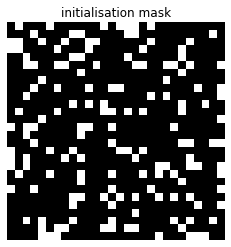

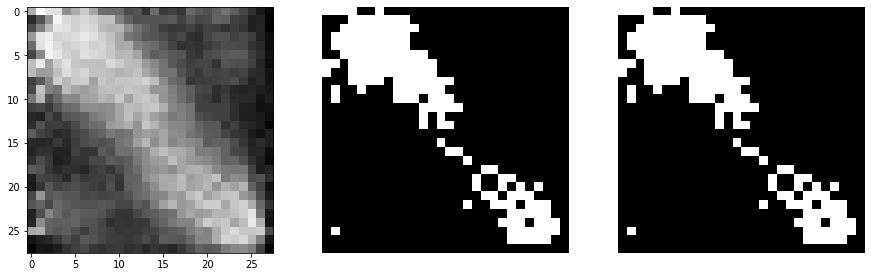


Train Epoch: 2 [0/60000 (0%)]	Loss: 32.3850








































































































































































































Train Epoch: 2 [25600/60000 (43%)]	Loss: 29.2734








































































































































































































Train Epoch: 2 [51200/60000 (85%)]	Loss: 29.9535




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 0.1816


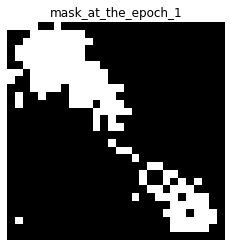

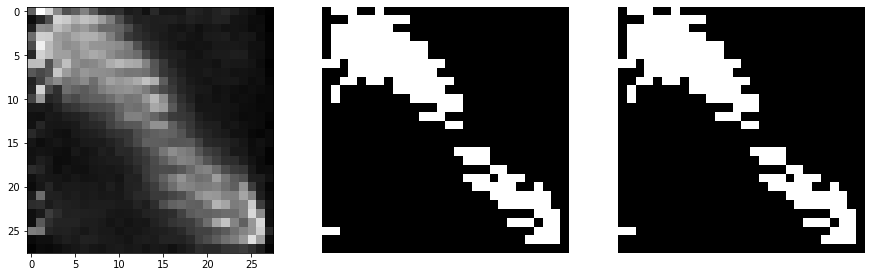


Train Epoch: 3 [0/60000 (0%)]	Loss: 30.1744








































































































































































































Train Epoch: 3 [25600/60000 (43%)]	Loss: 31.0350








































































































































































































Train Epoch: 3 [51200/60000 (85%)]	Loss: 27.7937




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 0.1393


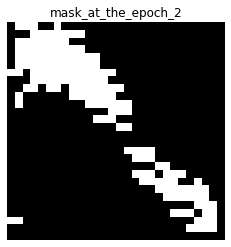

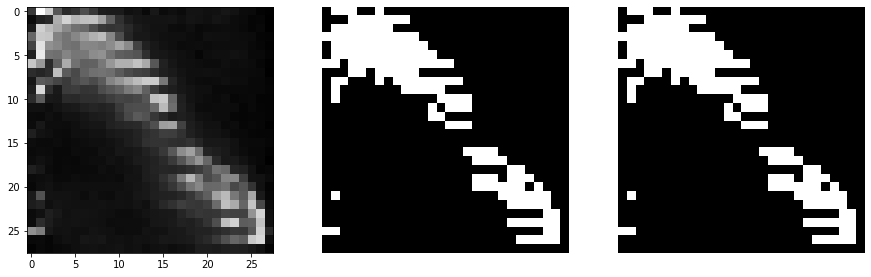


Train Epoch: 4 [0/60000 (0%)]	Loss: 29.4214








































































































































































































Train Epoch: 4 [25600/60000 (43%)]	Loss: 29.7316








































































































































































































Train Epoch: 4 [51200/60000 (85%)]	Loss: 30.9739




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 0.1657


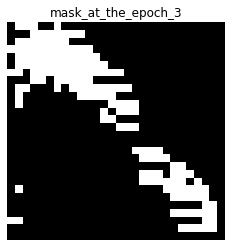

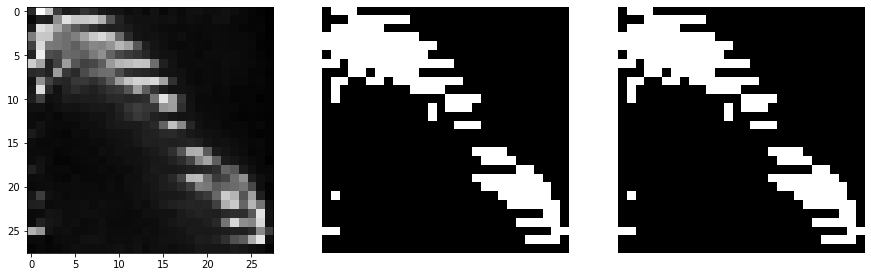


Train Epoch: 5 [0/60000 (0%)]	Loss: 29.0301








































































































































































































Train Epoch: 5 [25600/60000 (43%)]	Loss: 30.2245








































































































































































































Train Epoch: 5 [51200/60000 (85%)]	Loss: 28.6164




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 0.1038


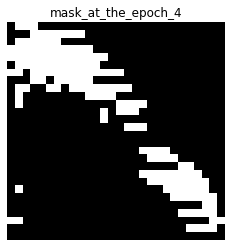

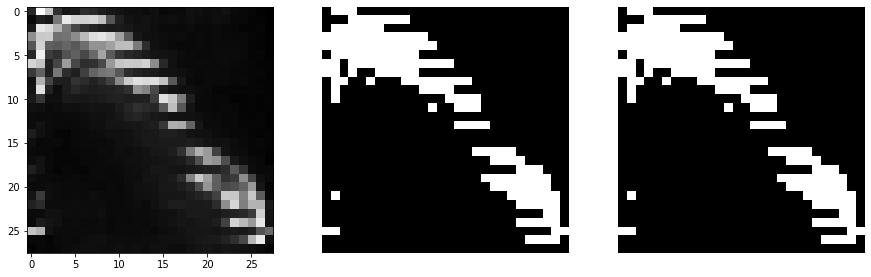


Train Epoch: 6 [0/60000 (0%)]	Loss: 30.0823








































































































































































































Train Epoch: 6 [25600/60000 (43%)]	Loss: 29.0488








































































































































































































Train Epoch: 6 [51200/60000 (85%)]	Loss: 30.8210




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 0.1163


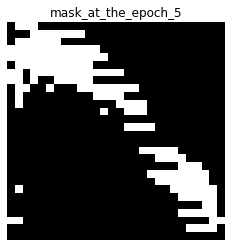

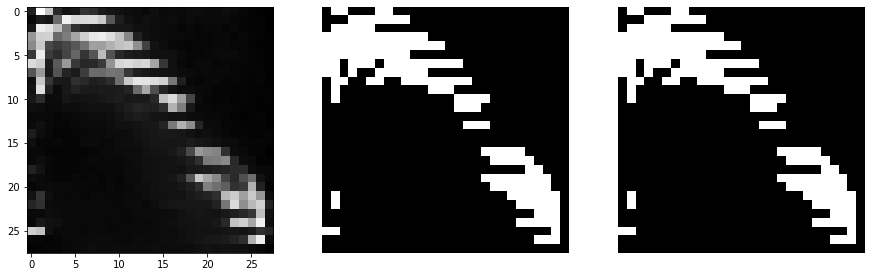


Train Epoch: 7 [0/60000 (0%)]	Loss: 29.6822








































































































































































































Train Epoch: 7 [25600/60000 (43%)]	Loss: 31.6774








































































































































































































Train Epoch: 7 [51200/60000 (85%)]	Loss: 31.8570




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 0.0918


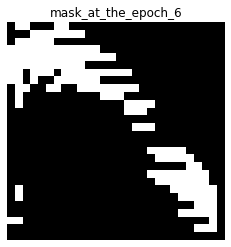

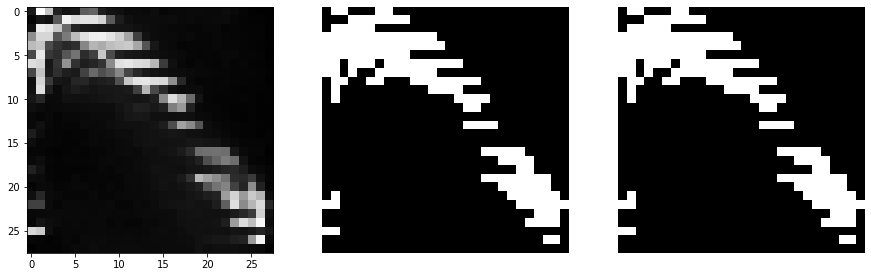


Train Epoch: 8 [0/60000 (0%)]	Loss: 31.3051








































































































































































































Train Epoch: 8 [25600/60000 (43%)]	Loss: 31.0934








































































































































































































Train Epoch: 8 [51200/60000 (85%)]	Loss: 29.6143




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 0.0794


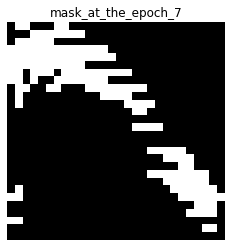

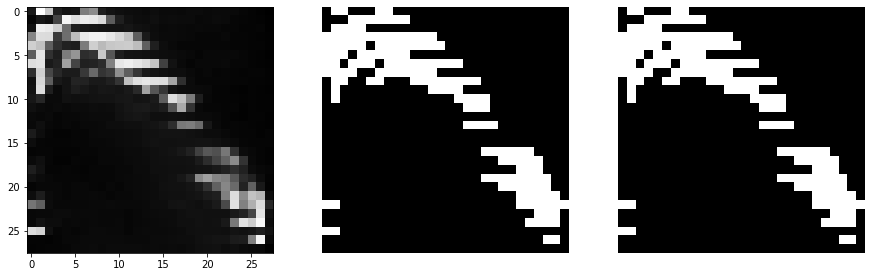


Train Epoch: 9 [0/60000 (0%)]	Loss: 30.5209








































































































































































































Train Epoch: 9 [25600/60000 (43%)]	Loss: 30.5594








































































































































































































Train Epoch: 9 [51200/60000 (85%)]	Loss: 29.8892




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 0.0698


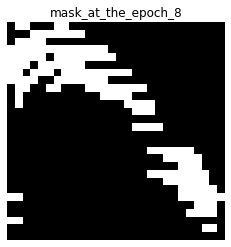

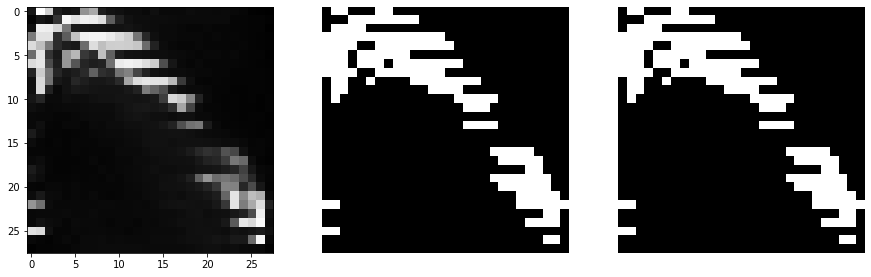


Train Epoch: 10 [0/60000 (0%)]	Loss: 29.9752








































































































































































































Train Epoch: 10 [25600/60000 (43%)]	Loss: 30.1476








































































































































































































Train Epoch: 10 [51200/60000 (85%)]	Loss: 31.1431




































































test at the end of epoch








































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 0.1592


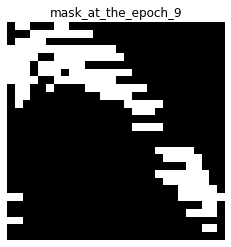

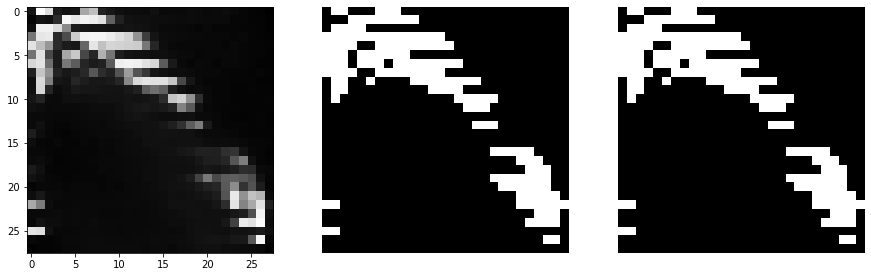

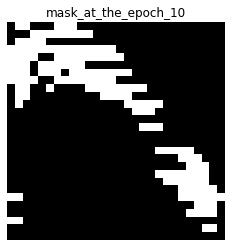

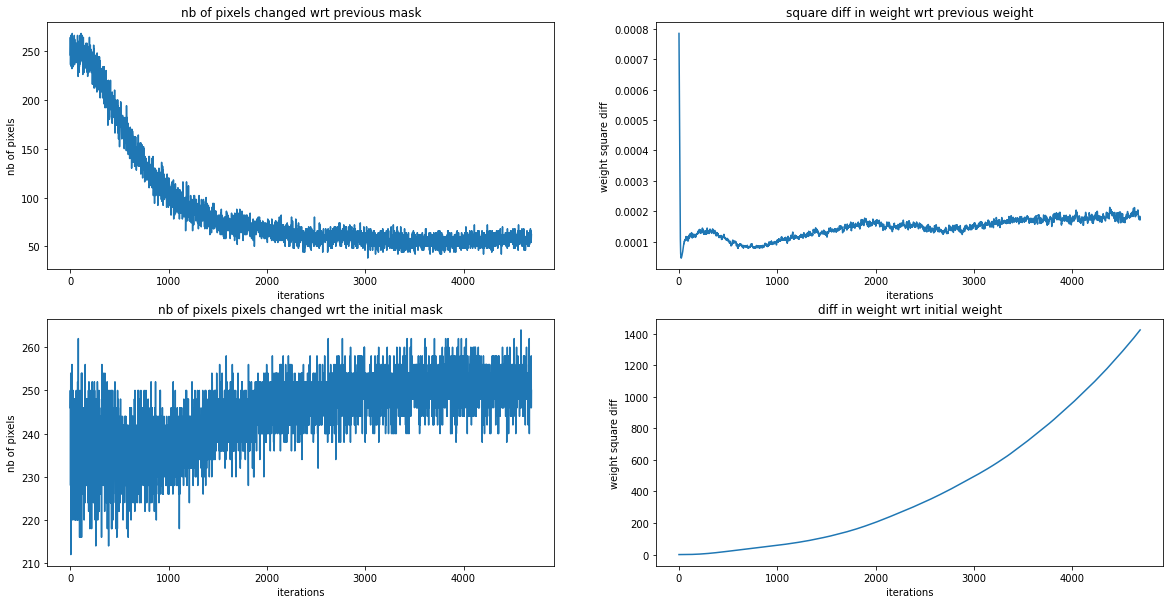

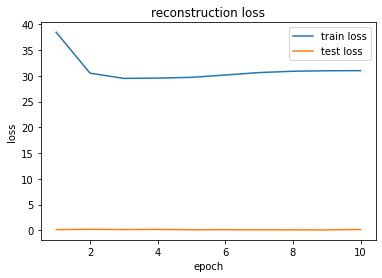

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")










































input_array shape:  (10000, 1, 28, 28, 2)

Test set: Avg. loss: 0.1643


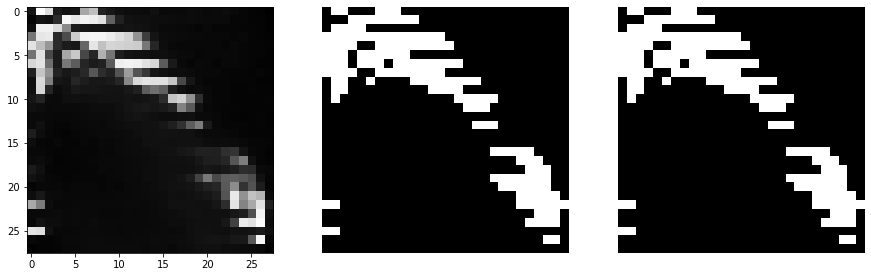

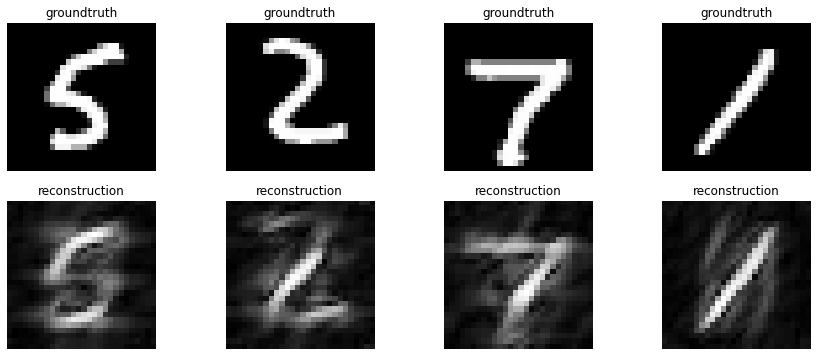

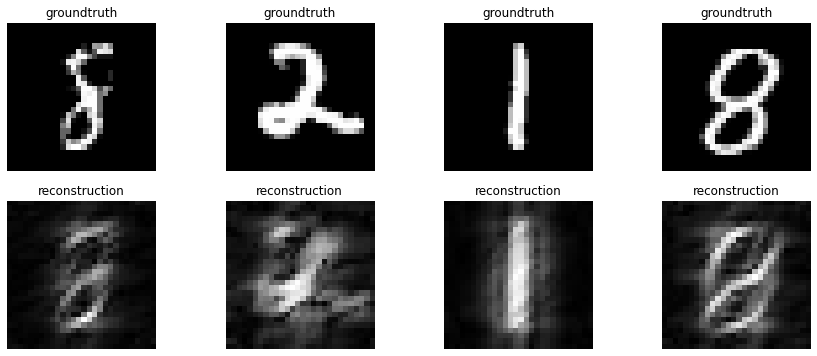

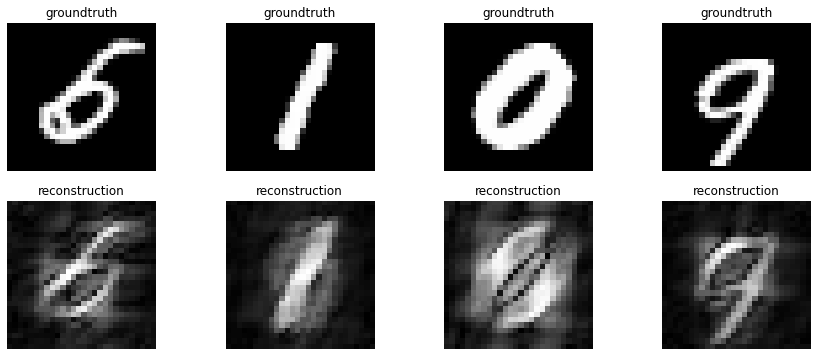

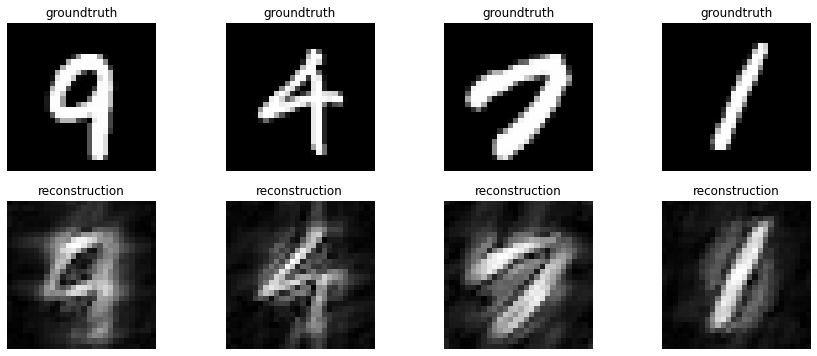

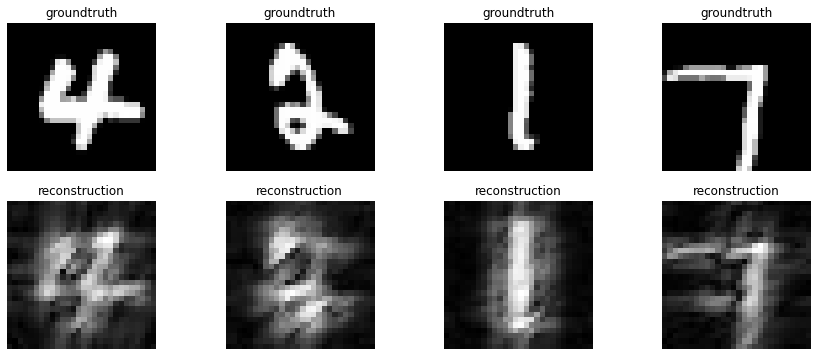

{'test_ssim': 0.4444223586922845, 'test_psnr': 11.916535955566289}


Net(
  (conv_mask): ConvTranspose2d(1, 1, kernel_size=(28, 28), stride=(1, 1), bias=False)
  (DO1): Dropout(p=0.0, inplace=False)
  (noise): GaussianNoise()
  (binary_act_d): DeterministicBinaryActivation(
    (act): Hardsigmoid(
      (act): Hardtanh(min_val=-1.0, max_val=1.0)
    )
  )
  (binary_act_s): StochasticBinaryActivation(
    (act): Hardsigmoid(
      (act): Hardtanh(min_val=-1.0, max_val=1.0)
    )
  )
  (linear_sp): Sparsify1D_kactiveIOnline()
  (spirit_nn): ComplexstackSpirit(
    (body): ModuleList(
      (0): ComplexSpiritConvBlock(
        (model): Complexspirit2D(
          (conv1): complexConv2d(
            (conv_r): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
            (conv_i): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
          )
        )
      )
      (1): ComplexSpiritConvBlock(
        (model): Complexspirit2D(
          (conv1): complexConv2d(
            (conv_r): Conv2d(1, 1, kernel_size=(

In [61]:
spirit_config_4 = {
    "batch_size": 128, 
    "kernel1": [5,5],
    "ncoils" : 1, 
    "nslices" : 1,
    "spirit_block" : 5,
    "std_noise": 0.05,
    "dropout_proba": 0.,
    "slice_dim" : (28,28),
    "multicoil": False,
    "mask_dim" : (28,28),
    "slope": 1,
    "complexe":True,
    "lr_mask": 1e-3,
    "lr_other": 1e-2,
    "spirit_activation": "none", ##activation function after spirit
    "batch_norm": False, #for bn_list
    "main_directory":".",
    "auxiliary":True,
    "weight_loss" :True,
    "acceleration": 0.2
}

run_model(spirit_config_4 )